In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
!pip install squarify
!pip install imblearn
!pip install catboost
!pip install category_encoders openpyxl --quiet
!pip install shap --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 93.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.0 MB/s eta 0:00:00


In [3]:
# 한글 폰트(NanumGothic) 설치
!apt-get update -qq
!apt-get install -qq -y fonts-nanum

# Matplotlib의 기본 폰트 설정
import matplotlib.font_manager as fm

plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

# NanumGothic 폰트 경로 확인 및 적용
font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"
fontprop = fm.FontProperties(fname=font_path, size=12)

# Matplotlib의 폰트 캐시 삭제 후 업데이트
fm.fontManager.addfont(font_path)  # 폰트 추가
plt.rc("font", family="NanumGothic")

print("한글 폰트 설정 완료!")

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package fonts-nanum.
(Reading database ... 126213 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
한글 폰트 설정 완료!


In [4]:
terror_1990 = pd.read_excel('/content/terror_data_city_filled.xlsx')

In [5]:
columns_to_keep = [
     'eventid',
    'iyear', 'imonth', 'iday',
    'success',
    'country_txt', 'region_txt', 'provstate',
    'latitude', 'longitude',
    'attacktype1_txt', 'targtype1_txt', 'natlty1_txt', 'weaptype1_txt',
    'nkill', 'nwound', 'city',
    'gname'
]

# 해당 컬럼만 선택
terror = terror_1990[columns_to_keep]

In [6]:
# 컬럼 명을 Country로 바꿈
terror.rename(columns={"country_txt":"Country"},inplace=True)

<ipython-input-6-e8a6cb500f78>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  terror.rename(columns={"country_txt":"Country"},inplace=True)


In [7]:
# 중복 제거 전 행 수 확인
print(f"중복 제거 전: {terror.shape[0]} rows")

# 'eventid'와 'Unnamed: 0' 제외한 컬럼 기준으로 중복 제거
terror = terror.drop_duplicates(subset=[col for col in terror.columns if col not in ['eventid', 'Unnamed: 0']])

# 중복 제거 후 행 수 확인
print(f"중복 제거 후: {terror.shape[0]} rows")

# 'Unnamed: 0' 컬럼 삭제
terror.drop(columns=['Unnamed: 0'], inplace=True, errors='ignore')

중복 제거 전: 173597 rows
중복 제거 후: 167694 rows


<ipython-input-7-8bdaa0f55496>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  terror.drop(columns=['Unnamed: 0'], inplace=True, errors='ignore')


In [8]:
terror_turkey = terror[terror['Country'] == 'Turkey']

In [9]:
# 공격 유형
attacktype_kor = {
    'Bombing/Explosion': '폭탄/폭발',
    'Armed Assault': '무장 공격',
    'Unarmed Assault': '비무장 공격',
    'Assassination': '암살',
    'Facility/Infrastructure Attack': '시설/인프라 공격',
    'Hijacking': '납치',
    'Hostage Taking (Kidnapping)': '인질 납치',
    'Hostage Taking (Barricade Incident)': '인질 점거',
    'Unknown': '알 수 없음'
}


# provstate
provstate_kor = {
    'Adana': '아다나', 'Adiyaman': '아디야만', 'Agri': '아으르', 'Amasya': '아마스야',
    'Ankara': '앙카라', 'Antalya': '안탈리아', 'Ardahan': '아르다한', 'Artvin': '아르트빈',
    'Aydin': '아이딘', 'Balikesir': '발리케시르', 'Batman': '바트만', 'Bingol': '빙괼',
    'Bitlis': '비틀리스', 'Burdur': '부르두르', 'Bursa': '부르사', 'Cankiri': '잔크르',
    'Corum': '조룸', 'Diyarbakir': '디야르바크르', 'Edirne': '에디르네', 'Elazig': '엘라즈으',
    'Erzincan': '에르진잔', 'Erzurum': '에르주룸', 'Eskisehir': '에스키셰히르',
    'Gaziantep': '가지안테프', 'Giresun': '기레순', 'Gumushane': '귀뮈샤네',
    'Hakkari': '하카리', 'Hatay': '하타이', 'Igdir': '으으드르', 'Isparta': '이스파르타',
    'Istanbul': '이스탄불', 'Izmir': '이즈미르', 'Kahramanmaras': '카흐라만마라슈',
    'Kars': '카르스', 'Kastamonu': '카스타모누', 'Kayseri': '카이세리', 'Kilis': '킬리스',
    'Kinkkale': '킹칼레', 'Kirikkale': '크르칼레', 'Kirsehir': '크르셰히르', 'Kocaeli': '코자엘리',
    'Konya': '콘야', 'Kutahya': '퀴타히야', 'Malatya': '말라티아', 'Manisa': '마니사',
    'Mardin': '마르딘', 'Mersin': '메르신', 'Mugla': '무을라', 'Mus': '무슈', 'Nigde': '니데',
    'Ordu': '오르두', 'Osmaniye': '오스마니예', 'Sakarya': '사카리야', 'Samsun': '삼순',
    'Sanliurfa': '샨르우르파', 'Siirt': '시이르트', 'Sinop': '시노프', 'Sirnak': '쉬르낙',
    'Sivas': '시바스', 'Tokat': '토카트', 'Trabzon': '트라브존', 'Tunceli': '툰젤리',
    'Unknown': '미상', 'Van': '반', 'Zinguldak': '진굴다크'
}
# 무기
weapon_type_mapping = {
    "Explosives": "폭발물",
    "Firearms": "화기",
    "Unknown": "알 수 없음",
    "Incendiary": "방화물",
    "Melee": "근접 무기",
    "Chemical": "화학 물질",
    "Vehicle (not to include vehicle-borne explosives, i.e., car or truck bombs)": "차량 (차량 폭탄 제외)",
    "Sabotage Equipment": "파괴 장비",
    "Other": "기타",
    "Biological": "생물학 무기",
    "Fake Weapons": "가짜 무기",
    "Radiological": "방사능 무기"
}
# 타겟
target_mapping = {
    "Abortion Related": "낙태 시술소 관련",
    "Airports & Aircraft": "공항 및 항공기",
    "Business": "사업체",
    "Educational Institution": "교육 기관",
    "Food or Water Supply": "식량 또는 수도",
    "Government (Diplomatic)": "정부 (외교)",
    "Government (General)": "정부 (일반)",
    "Journalists & Media": "언론 및 미디어",
    "Maritime": "해상",
    "Military": "군",
    "NGO": "비정부기구",
    "Other": "기타",
    "Police": "경찰",
    "Private Citizens & Property": "민간인 및 재산",
    "Religious Figures/Institutions": "종교 인물/기관",
    "Telecommunication": "통신",
    "Terrorists/Non-State Militia": "테러리스트/비국가 민병대",
    "Tourists": "관광객",
    "Transportation": "교통",
    "Unknown": "알 수 없음",
    "Utilities": "공공시설",
    "Violent Political Party": "폭력적 정치단체"
}
# 지역
region_mapping = {
    "Middle East & North Africa": "중동 및 북아프리카",
    "South Asia": "남아시아",
    "Southeast Asia": "동남아시아",
    "Sub-Saharan Africa": "사하라 이남 아프리카",
    "Eastern Europe": "동유럽",
    "Western Europe": "서유럽",
    "East Asia": "동아시아",
    "Central Asia": "중앙아시아",
    "North America": "북아메리카",
    "South America": "남아메리카",
    "Central America & Caribbean": "중앙아메리카 및 카리브해",
    "Australasia & Oceania": "오세아니아"
}

#번역 적용
terror_turkey['attacktype1_txt'] = terror_turkey['attacktype1_txt'].map(attacktype_kor).fillna(terror_turkey['attacktype1_txt'])
terror_turkey['targtype1_txt'] = terror_turkey['targtype1_txt'].map(target_mapping).fillna(terror_turkey['targtype1_txt'])
terror_turkey['weaptype1_txt'] = terror_turkey['weaptype1_txt'].map(weapon_type_mapping).fillna(terror_turkey['weaptype1_txt'])
terror_turkey['region_txt'] = terror_turkey['region_txt'].map(region_mapping).fillna(terror_turkey['region_txt'])

# 미국 주 이름도 한글로 변환!
terror_turkey['provstate'] = terror_turkey['provstate'].map(provstate_kor).fillna(terror_turkey['provstate'])

<ipython-input-9-7120e3421ce0>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  terror_turkey['attacktype1_txt'] = terror_turkey['attacktype1_txt'].map(attacktype_kor).fillna(terror_turkey['attacktype1_txt'])
<ipython-input-9-7120e3421ce0>:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  terror_turkey['targtype1_txt'] = terror_turkey['targtype1_txt'].map(target_mapping).fillna(terror_turkey['targtype1_txt'])
<ipython-input-9-7120e3421ce0>:94: SettingWithCopyWarning: 
A value is trying to be set on a copy 

In [10]:
# 날짜 컬럼 생성 (결측값 방지용 try-except)
def get_weekday(row):
    try:
        date = pd.to_datetime(f"{int(row['iyear'])}-{int(row['imonth'])}-{int(row['iday'])}", errors='coerce')
        return date.day_name() if pd.notnull(date) else None
    except:
        return None

# 요일 컬럼 추가
terror_turkey['weekday'] = terror_turkey.apply(get_weekday, axis=1)
# 결측치 요일 → "Unknown"으로 대체
terror_turkey['weekday'] = terror_turkey['weekday'].fillna('Unknown')


<ipython-input-10-bafef8ea547f>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  terror_turkey['weekday'] = terror_turkey.apply(get_weekday, axis=1)
<ipython-input-10-bafef8ea547f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  terror_turkey['weekday'] = terror_turkey['weekday'].fillna('Unknown')


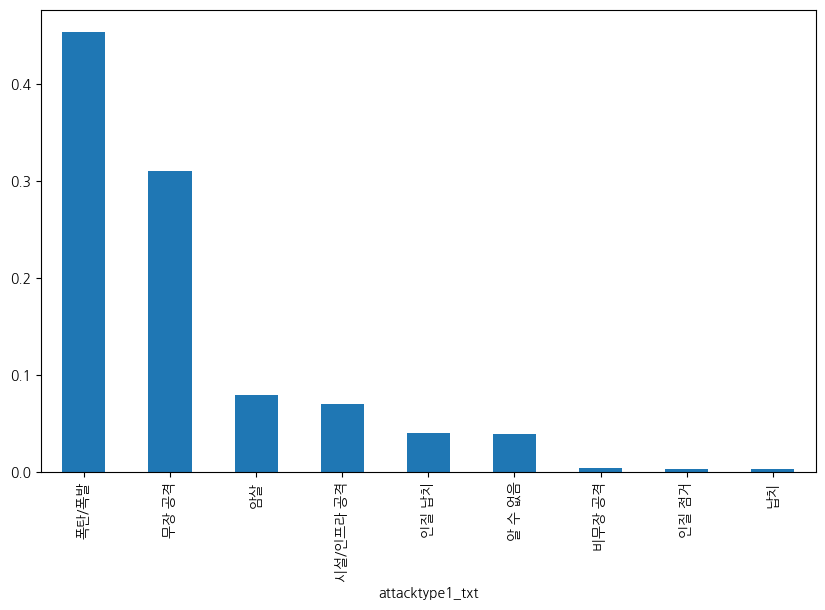

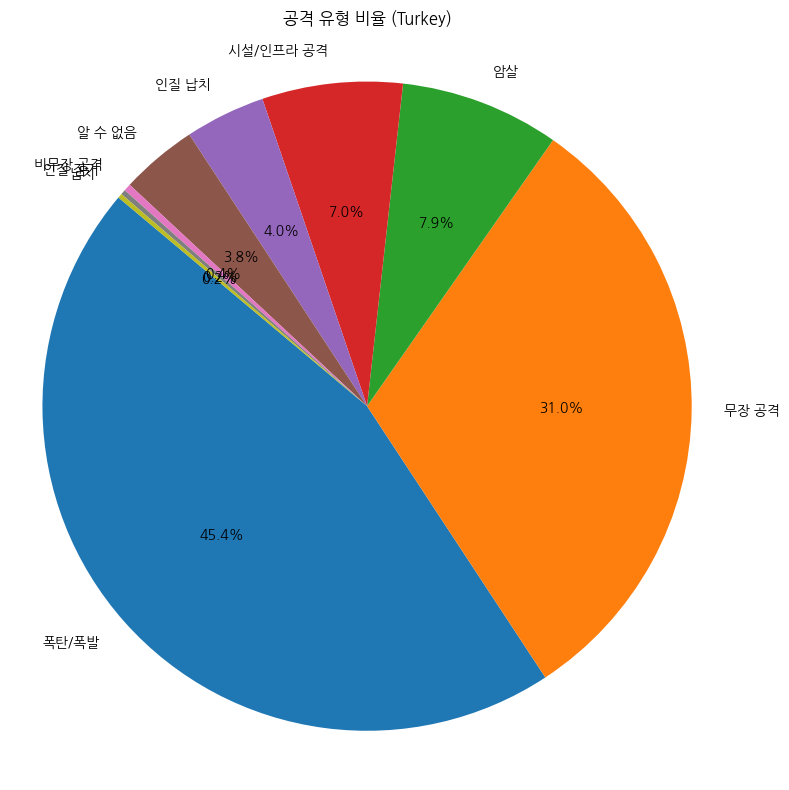

In [11]:
# Attack type proportions
attack_counts = terror_turkey['attacktype1_txt'].value_counts(normalize=True)

# Plotting - Vertical Bar Chart
plt.figure(figsize=(10, 6))
attack_counts.plot(kind='bar')

# 파이 차트로 시각화
plt.figure(figsize=(8, 8))
plt.pie(attack_counts, labels=attack_counts.index, autopct='%1.1f%%', startangle=140)
plt.title("공격 유형 비율 (Turkey)")
plt.axis('equal')  # 동그란 원 유지
plt.tight_layout()
plt.show()

attacktype1_txt
암살           0.765734
알 수 없음       0.884058
인질 점거        0.888889
폭탄/폭발        0.895961
비무장 공격       0.923077
무장 공격        0.948122
시설/인프라 공격    0.964286
인질 납치        0.993056
납치           1.000000
Name: success, dtype: float64


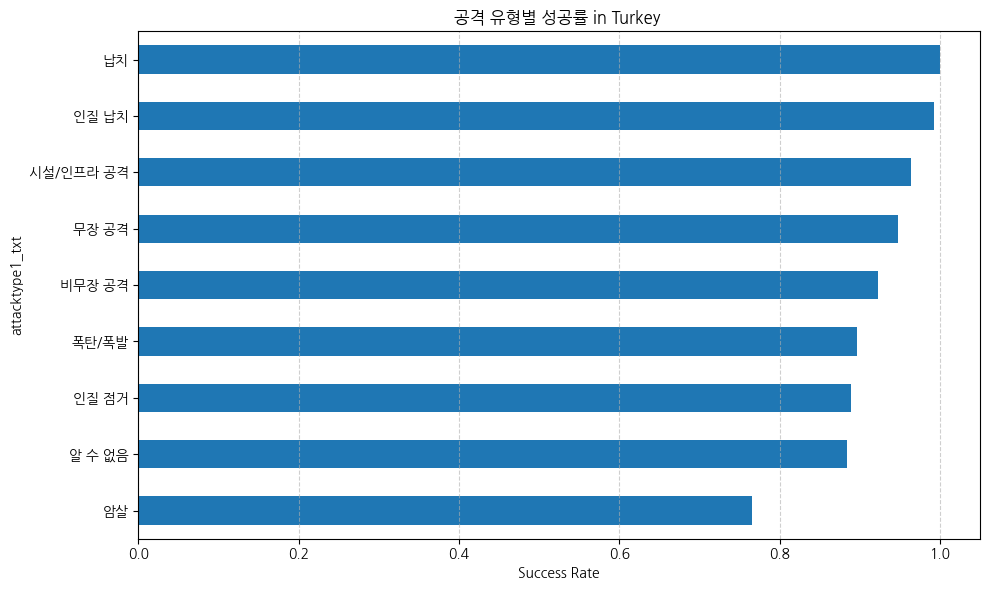

In [12]:
# 공격 유형별 성공률 계산
attack_success_rate = terror_turkey.groupby('attacktype1_txt')['success'].mean().sort_values()
print(attack_success_rate)
# 시각화
plt.figure(figsize=(10, 6))
attack_success_rate.plot(kind='barh')
plt.xlabel('Success Rate')
plt.title('공격 유형별 성공률 in Turkey ')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [46]:
from scipy.stats import chi2_contingency

# 공격유형 vs 성공여부 교차표 생성
crosstab = pd.crosstab(terror_turkey['attacktype1_txt'], terror_turkey['success'])

# 카이제곱 독립성 검정 수행
chi2, p, dof, expected = chi2_contingency(crosstab)

# 결과 정리
{
    "카이제곱 통계량": float(round(chi2, 3)),
    "p-value": float(round(p, 4)),
    "자유도": dof
}

{'카이제곱 통계량': 120.036, 'p-value': 0.0, '자유도': 8}

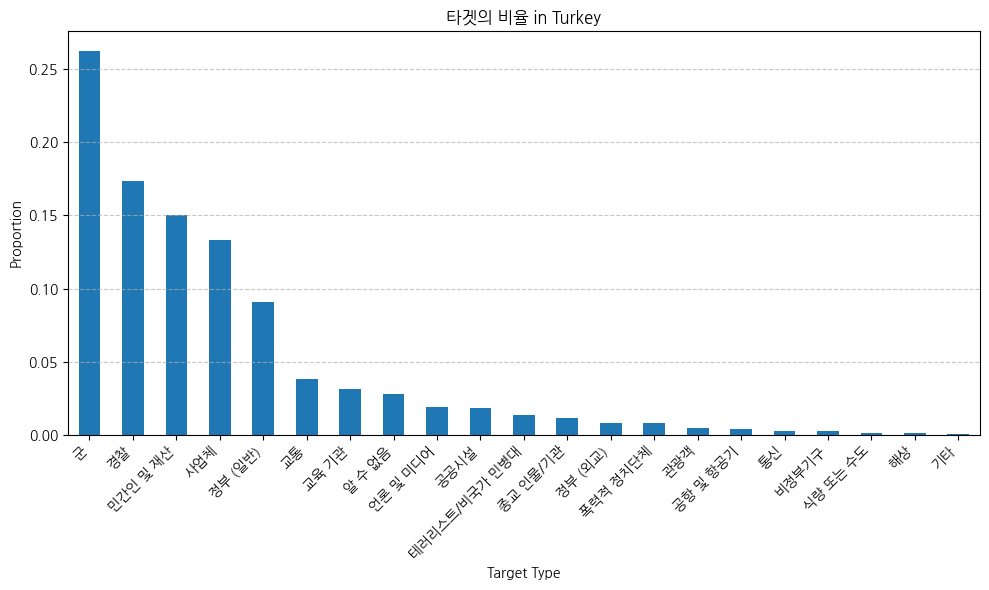

In [13]:
# Target type proportions
target_counts = terror_turkey['targtype1_txt'].value_counts(normalize=True)

# Plot
plt.figure(figsize=(10, 6))
target_counts.plot(kind='bar')

plt.ylabel('Proportion')
plt.xlabel('Target Type')
plt.title('타겟의 비율 in Turkey')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

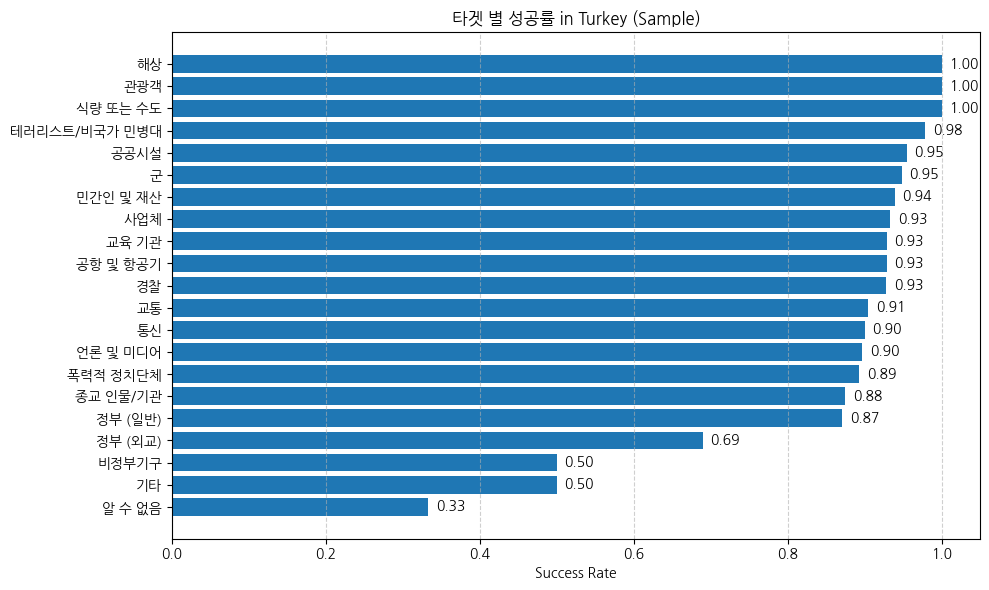

In [14]:
# 타겟 유형별 성공률 계산
target_success_rate = terror_turkey.groupby('targtype1_txt')['success'].mean().sort_values()

# 시각화 (성공률 값 포함)
plt.figure(figsize=(10, 6))
bars = plt.barh(target_success_rate.index, target_success_rate.values)

# 성공률 텍스트 추가
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.01, bar.get_y() + bar.get_height() / 2,
             f'{width:.2f}', va='center')

plt.xlabel('Success Rate')
plt.title('타겟 별 성공률 in Turkey (Sample)')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

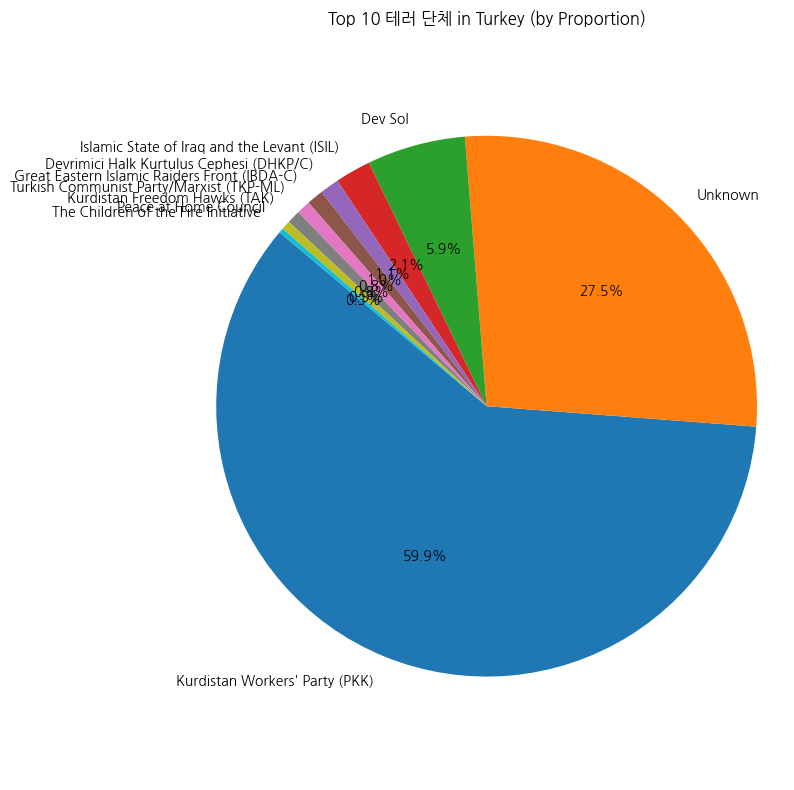

In [15]:
# gname 상위 10개 그룹 비율 계산 (터키 데이터 기준)
top_groups = terror_turkey['gname'].value_counts().nlargest(10)
top_groups_share = top_groups / top_groups.sum()

# 파이차트 시각화
plt.figure(figsize=(8, 8))
plt.pie(top_groups_share, labels=top_groups.index, autopct='%1.1f%%', startangle=140)
plt.title('Top 10 테러 단체 in Turkey (by Proportion)')
plt.axis('equal')  # 원형 유지
plt.tight_layout()
plt.show()

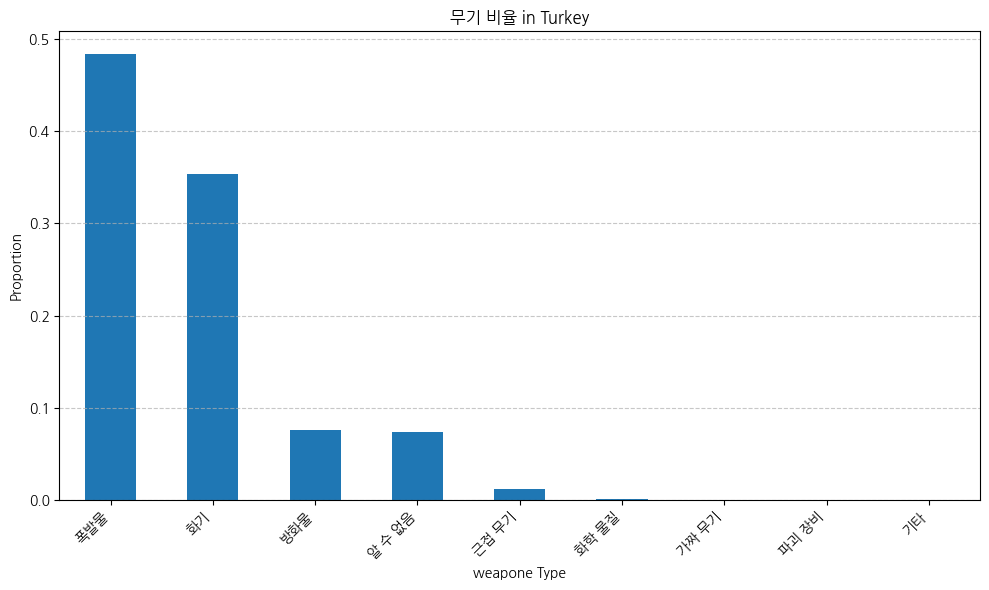

In [17]:
# Target type proportions
weap_count = terror_turkey['weaptype1_txt'].value_counts(normalize=True)

# Plot
plt.figure(figsize=(10, 6))
weap_count.plot(kind='bar')

plt.ylabel('Proportion')
plt.xlabel('weapone Type')
plt.title('무기 비율 in Turkey')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

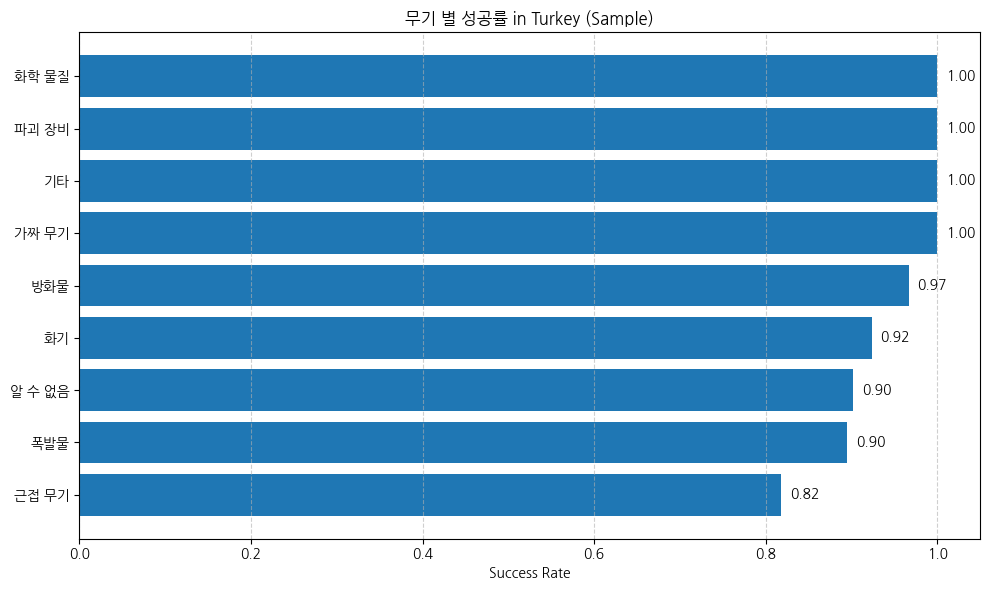

In [18]:
# 무기 유형별 성공률 계산
weapon_success_rate = terror_turkey.groupby('weaptype1_txt')['success'].mean().sort_values()

# 시각화 (성공률 값 포함)
plt.figure(figsize=(10, 6))
bars = plt.barh(weapon_success_rate.index, weapon_success_rate.values)

# 성공률 텍스트 추가
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.01, bar.get_y() + bar.get_height() / 2,
             f'{width:.2f}', va='center')

plt.xlabel('Success Rate')
plt.title('무기 별 성공률 in Turkey (Sample)')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

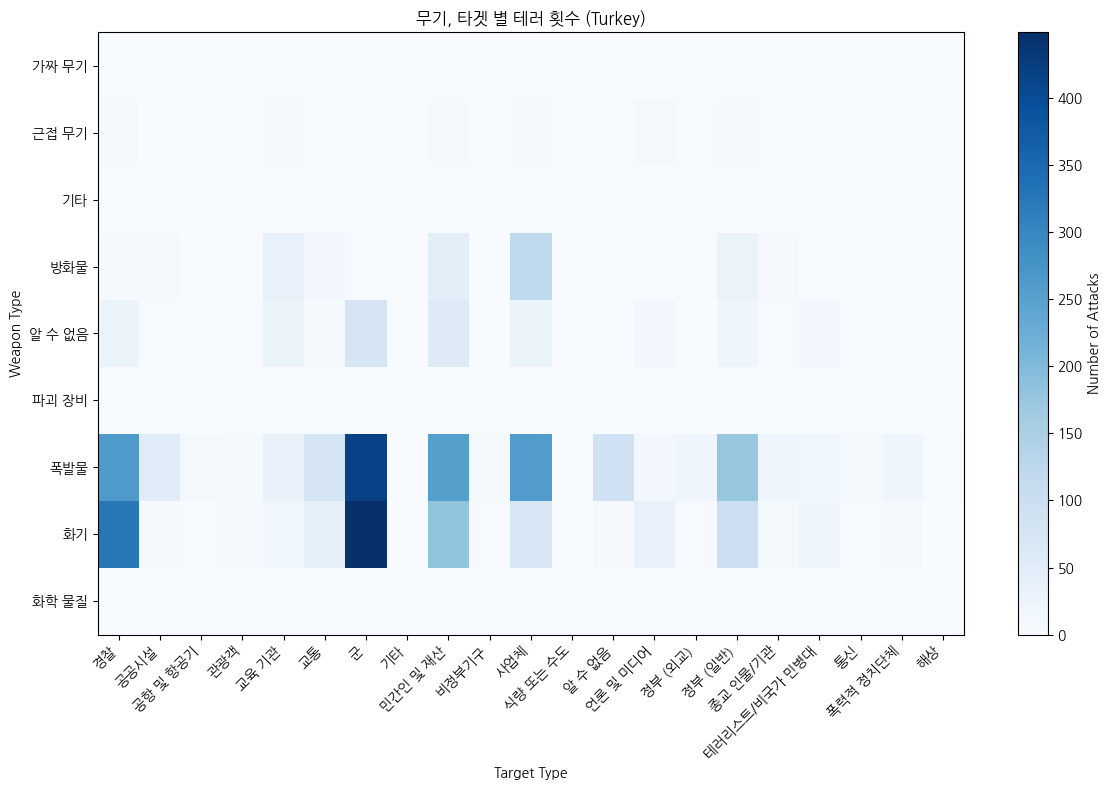

In [19]:
# 무기 유형과 타겟 유형 교차 빈도 테이블 생성
cross_tab = pd.crosstab(terror_turkey['weaptype1_txt'], terror_turkey['targtype1_txt'])

# 시각화 - heatmap 스타일
plt.figure(figsize=(12, 8))
plt.imshow(cross_tab, cmap='Blues', aspect='auto')
plt.colorbar(label='Number of Attacks')
plt.xticks(ticks=range(len(cross_tab.columns)), labels=cross_tab.columns, rotation=45, ha='right')
plt.yticks(ticks=range(len(cross_tab.index)), labels=cross_tab.index)
plt.title('무기, 타겟 별 테러 횟수 (Turkey)')
plt.xlabel('Target Type')
plt.ylabel('Weapon Type')
plt.tight_layout()
plt.show()

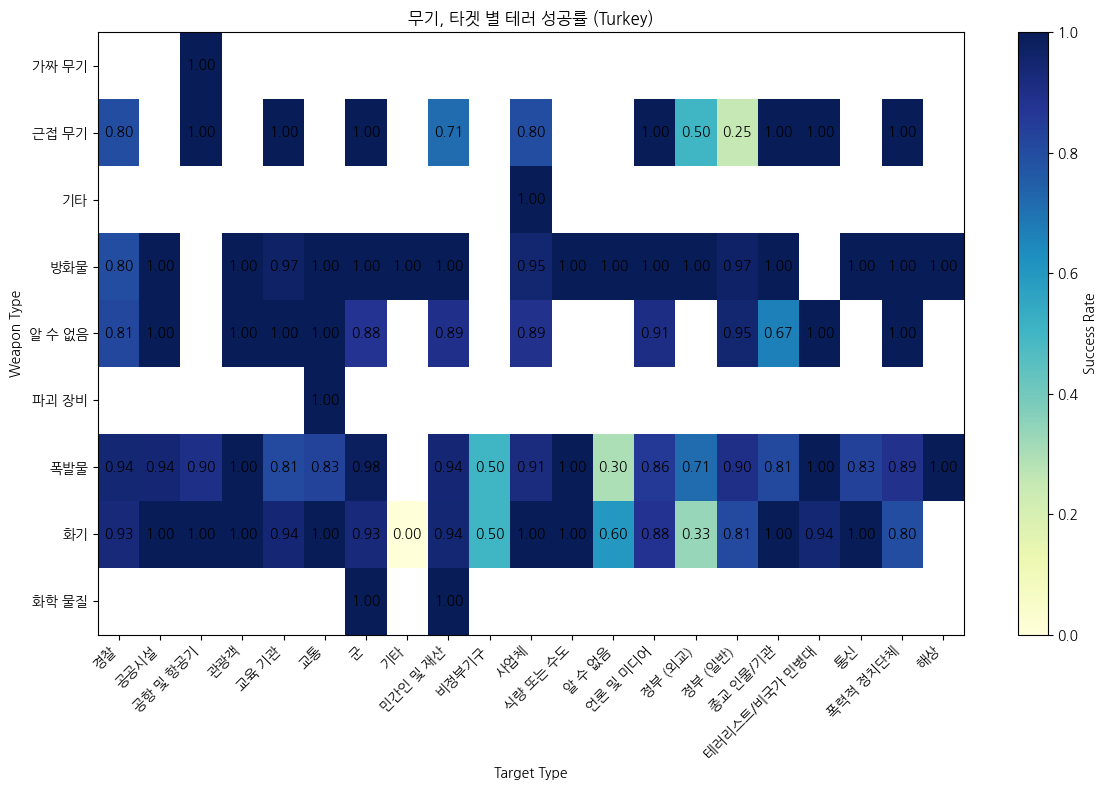

In [20]:
# 무기-타겟 조합별 성공률 계산
weapon_target_success = terror_turkey.groupby(['weaptype1_txt', 'targtype1_txt'])['success'].mean().unstack()

# 히트맵을 텍스트 포함으로 다시 그림
plt.figure(figsize=(12, 8))
plt.imshow(weapon_target_success, cmap='YlGnBu', aspect='auto', vmin=0, vmax=1)
plt.colorbar(label='Success Rate')

# 축 설정
xticks = range(len(weapon_target_success.columns))
yticks = range(len(weapon_target_success.index))
plt.xticks(ticks=xticks, labels=weapon_target_success.columns, rotation=45, ha='right')
plt.yticks(ticks=yticks, labels=weapon_target_success.index)

# 셀마다 성공률 값 텍스트 추가
for i in yticks:
    for j in xticks:
        value = weapon_target_success.iloc[i, j]
        if pd.notna(value):
            plt.text(j, i, f'{value:.2f}', ha='center', va='center', color='black')

plt.title('무기, 타겟 별 테러 성공률 (Turkey)')
plt.xlabel('Target Type')
plt.ylabel('Weapon Type')
plt.tight_layout()
plt.show()

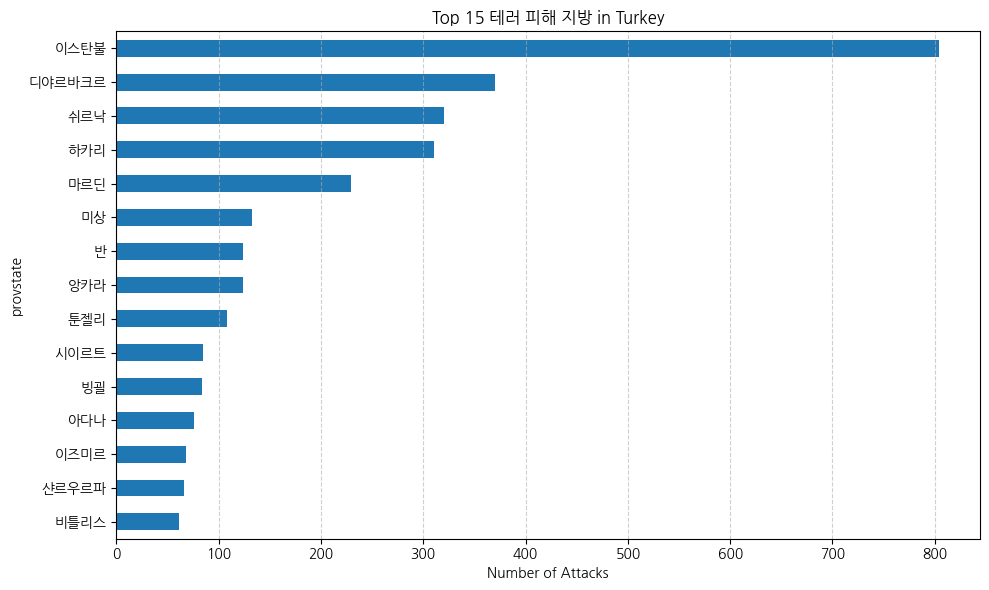

In [22]:
# 주(state)별 테러 발생 건수 계산 (상위 15개)
state_counts = terror_turkey['provstate'].value_counts().head(15).sort_values()

# 시각화
plt.figure(figsize=(10, 6))
state_counts.plot(kind='barh')
plt.xlabel('Number of Attacks')
plt.title('Top 15 테러 피해 지방 in Turkey')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

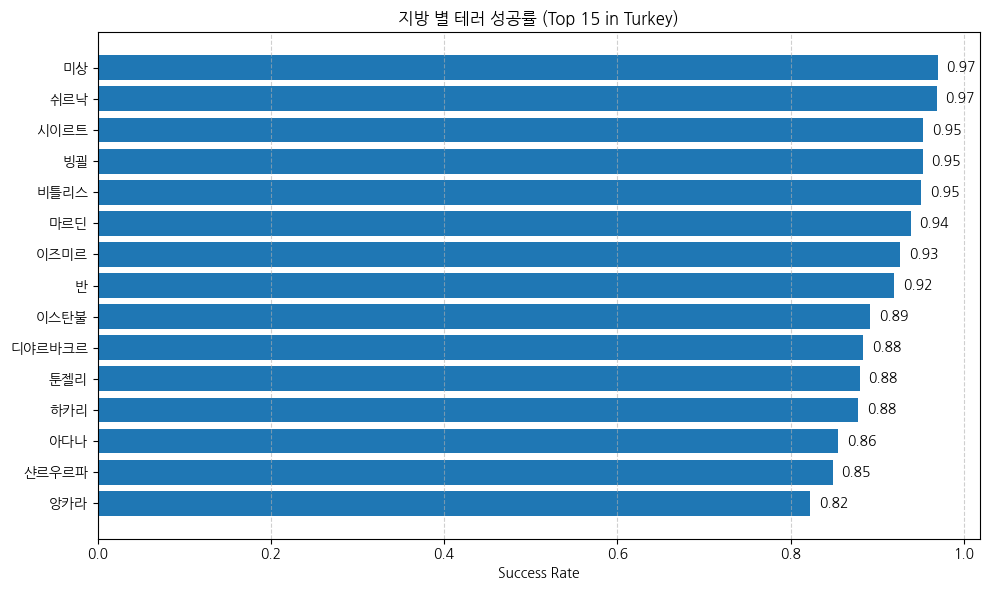

In [23]:
top15_states = terror_turkey['provstate'].value_counts().head(15).index

# 해당 주들만 필터링 후 성공률 계산
state_success_rate = terror_turkey[terror_turkey['provstate'].isin(top15_states)].groupby('provstate')['success'].mean().sort_values()

# 시각화
plt.figure(figsize=(10, 6))
bars = plt.barh(state_success_rate.index, state_success_rate.values)

# 성공률 텍스트 표시
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.01, bar.get_y() + bar.get_height() / 2,
             f'{width:.2f}', va='center')

plt.xlabel('Success Rate')
plt.title('지방 별 테러 성공률 (Top 15 in Turkey)')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

추정 보안 정책 (유효도 순)

1) 가장 중요한 타겟: targtype1_txt_Unknown, Government, Transportation

정책: 개인 무죄인 타겟 없음(가사화), 국가 군사/게이미 관련 기관, 교통 기관 및 시설의 보호 강화

구체 방안:

- 출입 통제 강화

- CCTV 설치, 발사법 대비 수치

- 의심스러운 행동 AI 검사

2) 가장 위험한 공격 유형: Assassination, Bombing, Melee

정책: 가장 복잡한 공격 유형에 대한 전문 검용 보건 강화

구체 방안:

- 폭발물 탐지 훈련 강화

- 정치인, 공지인 개인 건강 건물 검건 검토

- SNS/메시지 모니터링 통해 검사

3) 고위형 지역: Sirnak, Ankara, Adana, Diyarbakir

정책: 특정 지역에 대한 지역적 보안 개발

구체 방안:

- 지역 게이미, 경찰 강화 과 공조

- 특정 기간 (정치 경제 행사 시) 지방 감지 강화

4) 요일 효과: Sunday, Friday

정책: 특정 요일 방안 강화

구체 방안:

- 경찰/군 규모 양식 증가

- 공공 건설에 대한 통입 감지 강화

In [27]:
!pip install category_encoders

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:32:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score     support
Fail           0.800000  0.187500  0.303797   64.000000
Success        0.926346  0.995434  0.959648  657.000000
accuracy       0.923717  0.923717  0.923717    0.923717
macro avg      0.863173  0.591467  0.631723  721.000000
weighted avg   0.915130  0.923717  0.901431  721.000000


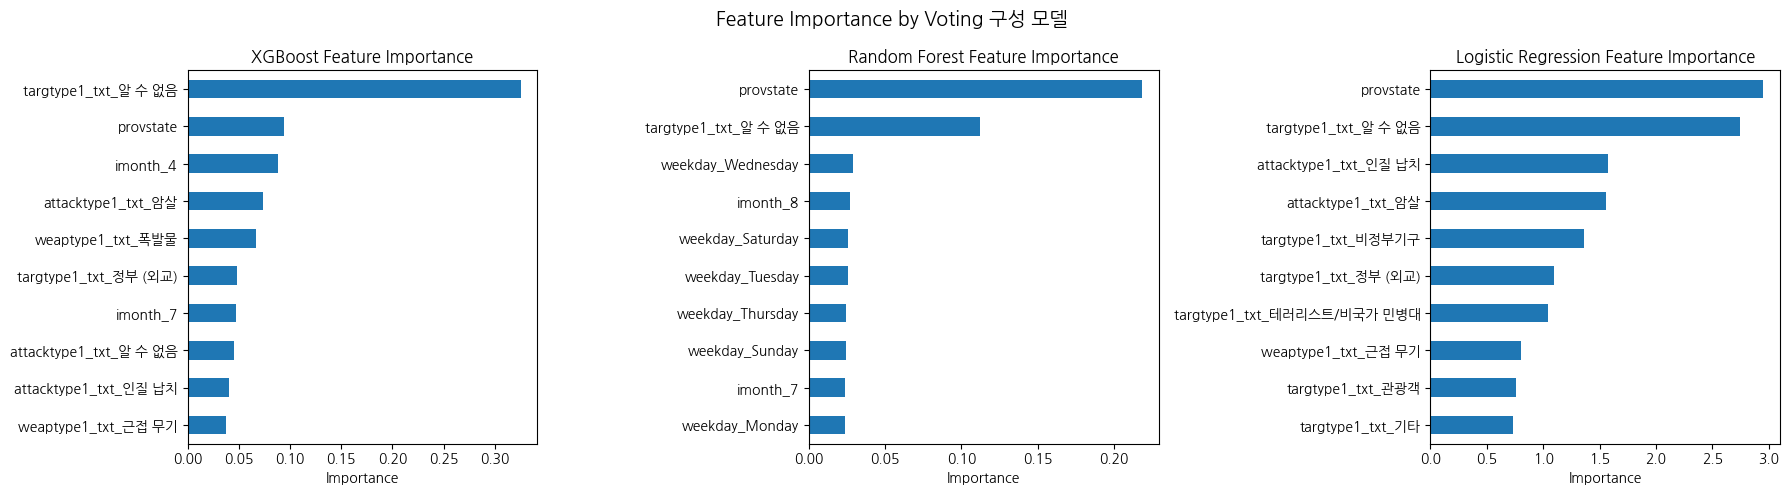

In [36]:
from category_encoders import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score, classification_report
import xgboost
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib


categorical_1hot = ['attacktype1_txt', 'targtype1_txt', 'weaptype1_txt', 'weekday', 'imonth']
categorical_target = ['provstate']
numeric = []
target = 'success'

# 결측치 제거 및 분할
data = terror_turkey[categorical_1hot + categorical_target + numeric + [target]].dropna()
X = data[categorical_1hot + categorical_target + numeric]
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 인코딩 구성
target_encoder = TargetEncoder()
X_train_prov = target_encoder.fit_transform(X_train[categorical_target], y_train)
X_test_prov = target_encoder.transform(X_test[categorical_target])

column_transformer = ColumnTransformer(transformers=[
    ('cat1hot', OneHotEncoder(handle_unknown='ignore'), categorical_1hot)#,
    #('num', SimpleImputer(strategy='mean'), numeric)
])
X_train_rest = column_transformer.fit_transform(X_train)
X_test_rest = column_transformer.transform(X_test)

# 컬럼명 구성
ohe = column_transformer.named_transformers_['cat1hot']
onehot_feature_names = ohe.get_feature_names_out(categorical_1hot)
final_feature_names = list(onehot_feature_names) + numeric + categorical_target

# 데이터프레임 생성
X_train_rest_df = pd.DataFrame(X_train_rest.toarray() if hasattr(X_train_rest, "toarray") else X_train_rest,
                               columns=list(onehot_feature_names) + numeric)
X_test_rest_df = pd.DataFrame(X_test_rest.toarray() if hasattr(X_test_rest, "toarray") else X_test_rest,
                              columns=list(onehot_feature_names) + numeric)

X_train_encoded = pd.concat([X_train_rest_df.reset_index(drop=True), X_train_prov.reset_index(drop=True)], axis=1)
X_test_encoded = pd.concat([X_test_rest_df.reset_index(drop=True), X_test_prov.reset_index(drop=True)], axis=1)
X_train_encoded.columns = final_feature_names
X_test_encoded.columns = final_feature_names

# Voting 모델 정의 및 학습
tuned_xgb = xgboost.XGBClassifier(
    learning_rate=0.05,
    max_depth=3,
    n_estimators=50,
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)
rf_model = RandomForestClassifier(random_state=42)
lr_model = LogisticRegression(max_iter=1000, random_state=42)

voting_model_tuned = VotingClassifier(
    estimators=[('xgb', tuned_xgb), ('rf', rf_model), ('lr', lr_model)],
    voting='soft'
)
voting_model_tuned.fit(X_train_encoded, y_train)

#  예측
y_pred_voting = voting_model_tuned.predict(X_test_encoded)

# 성능표 생성
report_dict = classification_report(y_test, y_pred_voting, target_names=["Fail", "Success"], output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

# 보기 좋게 정리
report_df = report_df[['precision', 'recall', 'f1-score', 'support']]
print(report_df)

# 중요도 추출 및 시각화
xgb_model_final = voting_model_tuned.named_estimators_['xgb']
xgb_importances = pd.Series(xgb_model_final.feature_importances_, index=final_feature_names).sort_values(ascending=False)

rf_model_final = voting_model_tuned.named_estimators_['rf']
rf_importances = pd.Series(rf_model_final.feature_importances_, index=final_feature_names).sort_values(ascending=False)

lr_model_final = voting_model_tuned.named_estimators_['lr']
lr_importances = pd.Series(abs(lr_model_final.coef_[0]), index=final_feature_names).sort_values(ascending=False)

# 시각화
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
xgb_importances.head(10).plot(kind='barh', ax=axes[0], title='XGBoost Feature Importance')
rf_importances.head(10).plot(kind='barh', ax=axes[1], title='Random Forest Feature Importance')
lr_importances.head(10).plot(kind='barh', ax=axes[2], title='Logistic Regression Feature Importance')

for ax in axes:
    ax.invert_yaxis()
    ax.set_xlabel("Importance")

plt.suptitle("Feature Importance by Voting 구성 모델 ", fontsize=14)
plt.tight_layout()
plt.show()

# 모델과 데이터 저장 (현재 디렉토리에 저장)
joblib.dump(xgb_model_final, "xgb_model.pkl")
X_train_encoded.to_csv("X_train_encoded.csv", index=False)

1.  사용한 데이터 및 피처 구성
항목	설명
- 데이터	terror_turkey.xlsx (튀르키예 내 테러 사건 정보)
- 타겟	success (0: 실패, 1: 성공)
- 주요 피처	attacktype1_txt, targtype1_txt, weaptype1_txt, weekday, imonth, provstate

3.  피처 인코딩 전략

- 범주형 (해석 중요)
attacktype1_txt, targtype1_txt, weaptype1_txt, weekday
🎯 One-Hot Encoding
SHAP 및 정책 해석을 위해 범주 유지

- 범주형 (지역)
provstate
🎯 Target Encoding
지역별 성공률 요약으로 간결하게 처리

- 수치형
imonth
❌ 인코딩 없이 그대로 사용
계절/시기 정보 보존 목적


4.  모델 구성 (앙상블)
VotingClassifier (Soft Voting) – 세 모델의 예측 확률 평균을 사용하여 최종 예측


-  XGBoost	🎯 GridSearchCV로 튜닝된 성능 최적화 모델
-  Random Forest	분산 높은 피처에도 강한 트리 앙상블
-  Logistic Regression	해석 가능한 선형 모델 구성 포함

5. 🔍 Grid Search (튜닝)

- XGBoost
✅ 사용
learning_rate=0.05, max_depth=3, n_estimators=50
- RF, LR
❌ 기본 파라미터	(Voting 모델 내부에서만 사용)

In [25]:
!pip install shap --quiet

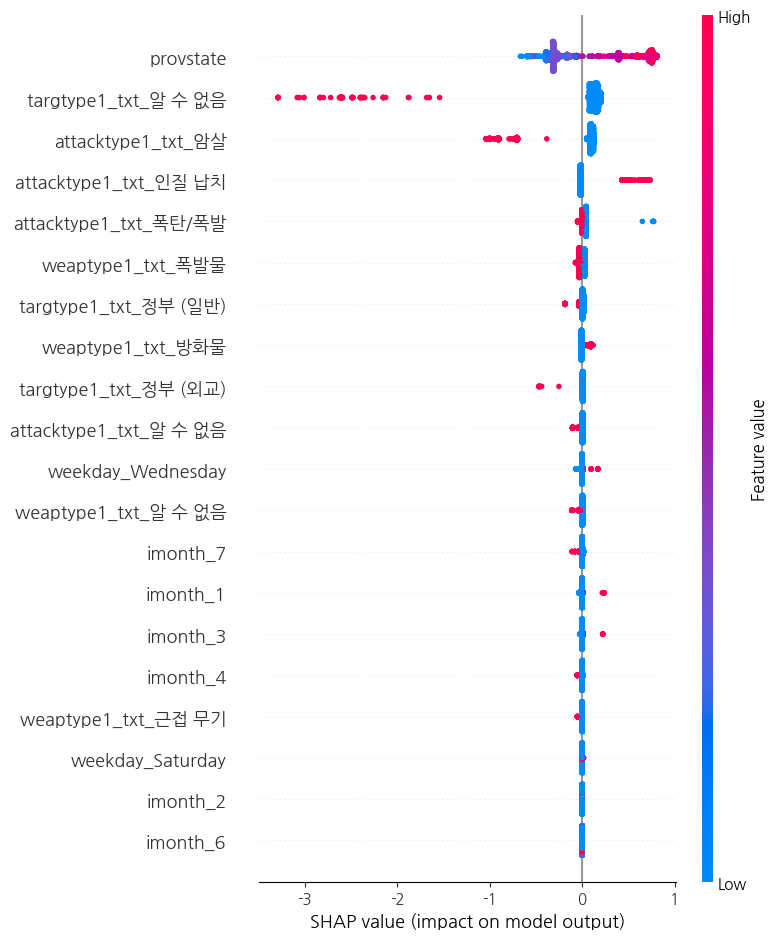

In [37]:
import shap
import joblib
import pandas as pd

# 모델 및 데이터 불러오기
model = joblib.load("xgb_model.pkl")
X = pd.read_csv("X_train_encoded.csv")

# SHAP 실행
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)


<ipython-input-34-8e5edd6961b0>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


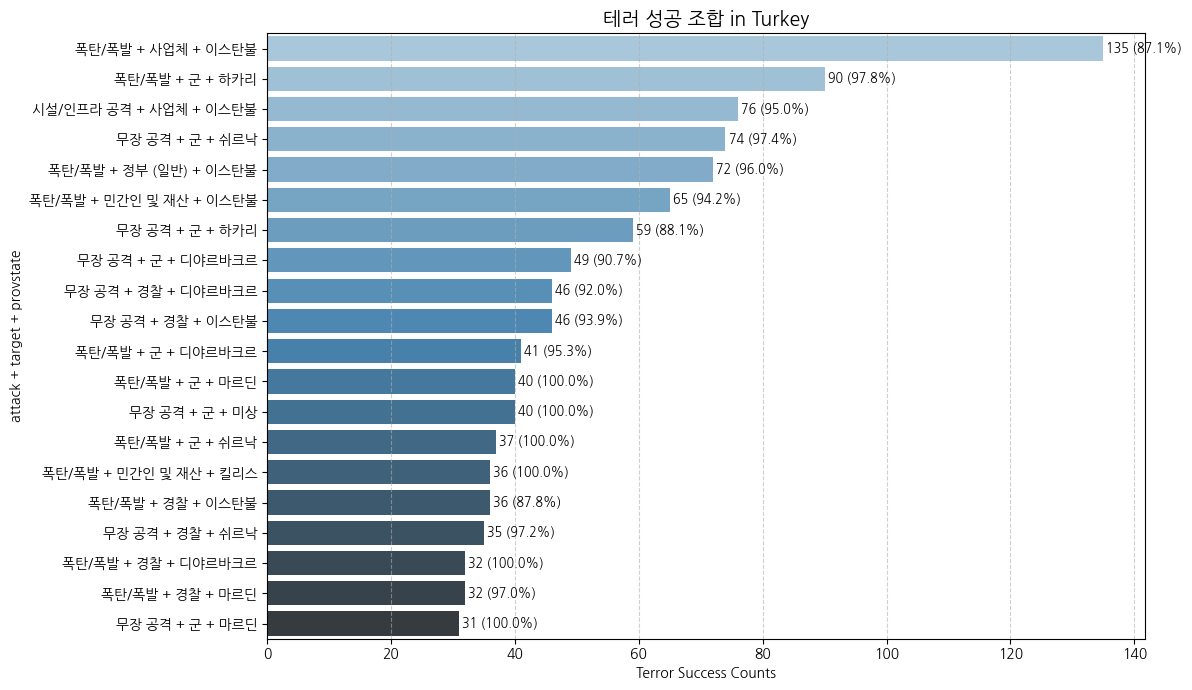

In [34]:
turkey_copy = terror_turkey.copy()

# 필요한 변수 추출
turkey_copy = turkey_copy[['attacktype1_txt', 'targtype1_txt', 'provstate', 'success']]

# 조합 그룹 만들기
turkey_copy['combination'] = turkey_copy['attacktype1_txt'] + ' + ' + turkey_copy['targtype1_txt'] + ' + ' + turkey_copy['provstate']

# 성공률 계산
grouped = turkey_copy.groupby('combination')['success'].agg(['count', 'sum']).reset_index()
grouped['success_rate'] = (grouped['sum'] / grouped['count']) * 100

# 상위 조합 추출 (데이터 수 10개 이상)
filtered = grouped[grouped['count'] >= 10]

# count 기준으로 정렬 (내림차순), 상위 50개 추출
top_combos = filtered.sort_values(by='sum', ascending=False).head(20)
top_combos
# 시각화
plt.figure(figsize=(12, 7))
sns.barplot(
    data=top_combos,
    y='combination',
    x='sum',
    palette='Blues_d'
)
plt.title('테러 성공 조합 in Turkey', fontsize=14)
plt.xlabel('Terror Success Counts')
plt.ylabel('attack + target + provstate')
plt.grid(axis='x', linestyle='--', alpha=0.6)

# 수치 라벨 표시 (성공횟수 + 성공률%)
for i, row in enumerate(top_combos.itertuples()):
    label = f"{int(row.sum)} ({row.success_rate:.1f}%)"
    plt.text(row.sum + 0.5, i, label, va='center', ha='left', fontsize=9)

plt.tight_layout()
plt.show()

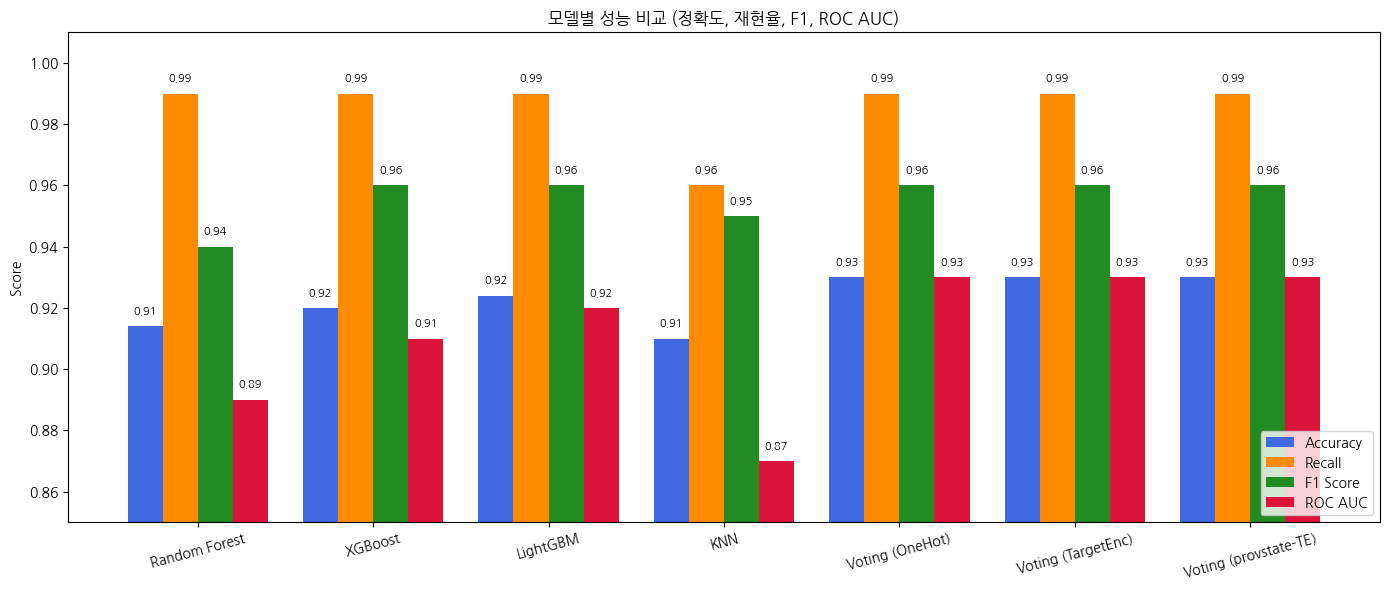

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# 원본 리스트
model_names = [
    'Random Forest', 'XGBoost', 'LightGBM', 'KNN',
    'Voting (OneHot)', 'Voting (TargetEnc)', 'Voting (최종)', 'Voting (provstate-TE)'
]

accuracies =   [0.914, 0.920, 0.924, 0.910, 0.930, 0.930, 0.930, 0.930]
recalls =      [0.99,  0.99,  0.99,  0.96,  0.99,  0.99,  0.99,  0.99 ]
f1_scores =    [0.94,  0.96,  0.96,  0.95,  0.96,  0.96,  0.96,  0.96 ]
roc_aucs =     [0.89,  0.91,  0.92,  0.87,  0.93,  0.93,  0.93,  0.93 ]

# 'Voting (최종)'의 인덱스
remove_idx = model_names.index('Voting (최종)')

# 해당 인덱스를 각 리스트에서 제거
model_names.pop(remove_idx)
accuracies.pop(remove_idx)
recalls.pop(remove_idx)
f1_scores.pop(remove_idx)
roc_aucs.pop(remove_idx)

# 시각화
x = np.arange(len(model_names))
width = 0.2

fig, ax = plt.subplots(figsize=(14, 6))
bar1 = ax.bar(x - 1.5*width, accuracies, width, label='Accuracy', color='royalblue')
bar2 = ax.bar(x - 0.5*width, recalls, width, label='Recall', color='darkorange')
bar3 = ax.bar(x + 0.5*width, f1_scores, width, label='F1 Score', color='forestgreen')
bar4 = ax.bar(x + 1.5*width, roc_aucs, width, label='ROC AUC', color='crimson')

ax.set_ylabel('Score')
ax.set_title('모델별 성능 비교 (정확도, 재현율, F1, ROC AUC)')
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=15)
ax.set_ylim(0.85, 1.01)
ax.legend(loc='lower right')

# 수치 표시
for i in range(len(model_names)):
    ax.annotate(f'{accuracies[i]:.2f}', xy=(x[i] - 1.5*width, accuracies[i] + 0.004), ha='center', fontsize=8)
    ax.annotate(f'{recalls[i]:.2f}',   xy=(x[i] - 0.5*width, recalls[i] + 0.004), ha='center', fontsize=8)
    ax.annotate(f'{f1_scores[i]:.2f}', xy=(x[i] + 0.5*width, f1_scores[i] + 0.004), ha='center', fontsize=8)
    ax.annotate(f'{roc_aucs[i]:.2f}',  xy=(x[i] + 1.5*width, roc_aucs[i] + 0.004), ha='center', fontsize=8)

plt.tight_layout()
plt.show()

# 가설 1 : 시간에 흐름에 따라 기술의 발전과 대응 매뉴얼 구비로 테러 성공률이 낮아질 것이다.

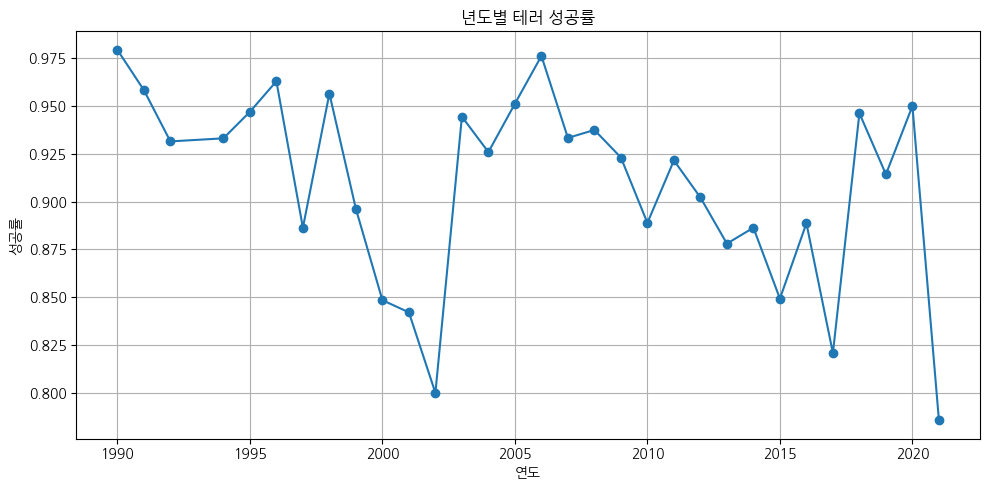

In [ ]:
# 가설 1: 시간 흐름에 따른 테러 성공률 변화
# 연도별 성공률 계산
success_by_year = terror.groupby('iyear')['success'].mean()

# 시각화 - 연도별 성공률 변화
plt.figure(figsize=(10, 5))
success_by_year.plot(marker='o')
plt.title('년도별 테러 성공률')
plt.ylabel('성공률')
plt.xlabel('연도')
plt.grid(True)
plt.tight_layout()
plt.show()



*   시간이 흐름에 따라 성공률이 낮아지는 것을 확인
*   년도별 공격유형을 분석



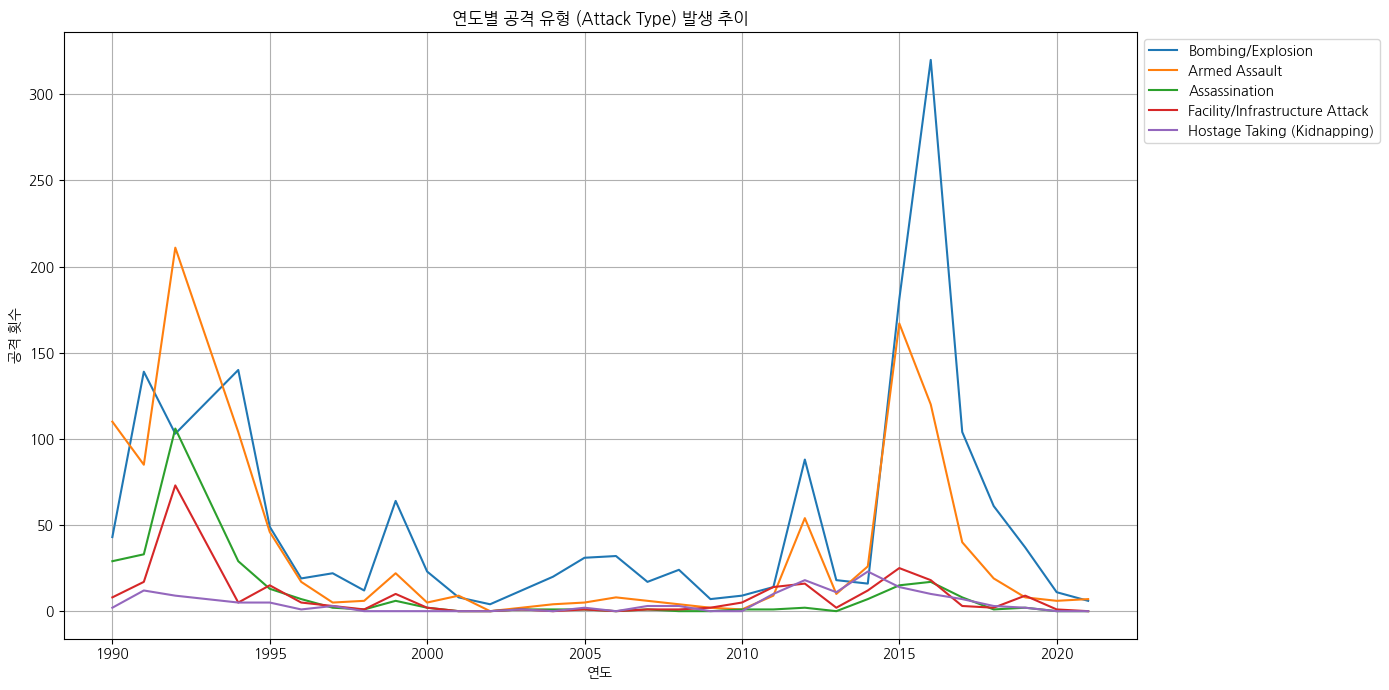

In [ ]:
# 연도별 attacktype1_txt 건수 집계
attack_count_by_year = terror.groupby(['iyear', 'attacktype1_txt']).size().unstack(fill_value=0)

# 상위 공격유형만 필터 (전체 수가 많은 유형 위주로)
top_types = terror['attacktype1_txt'].value_counts().head(5).index.tolist()
attack_count_by_year_top = attack_count_by_year[top_types]

# 그래프 출력
plt.figure(figsize=(14, 7))
for column in attack_count_by_year_top.columns:
    plt.plot(attack_count_by_year_top.index, attack_count_by_year_top[column], label=column)

plt.title("연도별 공격 유형 (Attack Type) 발생 추이")
plt.xlabel("연도")
plt.ylabel("공격 횟수")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.grid(True)
plt.show()



*   년도가 지날 수록 폭탄, 무장공격, 인질극 유형의 공격이 증가함을 확인
*   공격유형별 성공률을 년도에 따라 분석



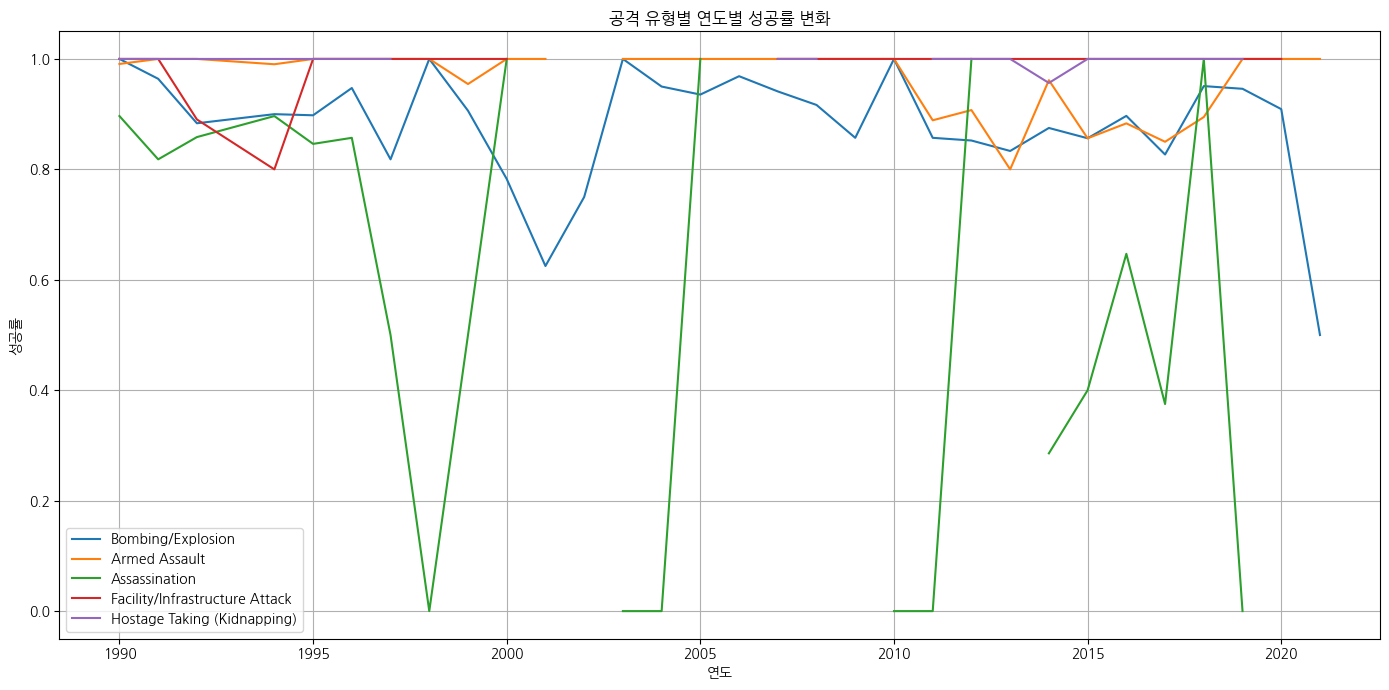

In [ ]:
# 연도-공격유형별 성공률 계산
success_by_year_type = terror.groupby(['iyear', 'attacktype1_txt'])['success'].mean().unstack()

# 상위 공격유형만 필터 (전체 수가 많은 유형 위주로)
top_types = terror['attacktype1_txt'].value_counts().head(5).index.tolist()
success_by_year_type_top = success_by_year_type[top_types]

# 시각화
plt.figure(figsize=(14, 7))
for col in success_by_year_type_top.columns:
    plt.plot(success_by_year_type_top.index, success_by_year_type_top[col], label=col)

plt.title("공격 유형별 연도별 성공률 변화")
plt.xlabel("연도")
plt.ylabel("성공률")
plt.legend(loc='lower left')
plt.grid(True)
plt.tight_layout()
plt.show()



*   폭탄, 무장공격, 인질극의 성공률이 떨어지는 것을 확인
*   폭탄, 무장공격, 인질극의 빈도 수가 많아지는 것과 반대로 성공률은 낮아지고 있어 전체적인 성공률이 낮아진다고 볼 수 있다.




1.   시민들의 경각심 상승으로 투철한 신고정신이 발달함
2.   공항, 기차역, 대형 행사장 등 주요 시설의 검색 시스템이 고도화되어 X-ray, 화학 센서, AI 기반 CCTV 등으로 폭발물 탐지가 빨라짐.











*   가설 1:
"시간이 흐를수록 테러 성공률이 낮아질 것이다."
→ 사용한 기법: 선형 회귀 분석 (Linear Regression)
*   이유:

1.   시간은 연속형 독립변수
2.   성공률은 연속형 종속변수
3.   즉, X(연도)가 증가함에 따라 Y(성공률)이 변하는지 확인하고 싶은 것
→ 이럴 땐 선형 회귀가 가장 적절


*   의문점


1.   시간이 흐를수록 성공률이 감소(기울기 < 0)하는가?
2.   이 관계가 우연인지 아닌지(p-value) 확인








In [ ]:
from scipy.stats import linregress

# 연도별 성공률 계산
success_by_year = terror.groupby('iyear')['success'].mean().reset_index()

# 선형 회귀 (시간의 흐름과 성공률 간 관계)
slope, intercept, r_value, p_value, std_err = linregress(success_by_year['iyear'], success_by_year['success'])

print("기울기 (slope):", slope)  # 음수면 성공률 감소
print("p-value:", p_value)       # 유의수준 확인
print("결정계수 (R²):", r_value**2)


기울기 (slope): -0.0025087449773147303
p-value: 0.0007837861779585792
결정계수 (R²): 0.3266391774483297


# 가설 2 : 종교에 따른 테러 위험성

4점부터 위험군에 속한다


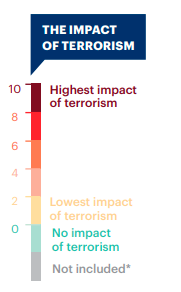


In [20]:
# GTI score(국가별 테러 위험도 데이터)
GTI_rank = pd.read_csv('/content/gti_2016_rank_1_to_130_complete.csv')

In [21]:
# GTI_score가 4 이상인 국가들 정리
high_GTI = GTI_rank[GTI_rank["GTI_Score"] >= 4].reset_index(drop=True)

In [22]:
# 나라별 종교 데이터
religion = pd.read_csv('/content/flags.csv', sep=";")

In [23]:
religion = religion[["name", "religion"]].copy()
religion.rename(columns={"name": "Country"}, inplace=True)

In [24]:
# 종교 코드 매핑 딕셔너리
religion_map = {
    0: "Catholic",
    1: "Other Christian",
    2: "Muslim",
    3: "Buddhist",
    4: "Hindu",
    5: "Ethnic",
    6: "Marxist",
    7: "Others"
}

religion["religion"] = religion["religion"].map(religion_map)
religion

,Country,religion
0,Afghanistan,Muslim
1,Albania,Marxist
2,Algeria,Muslim
3,American-Samoa,Other Christian
4,Andorra,Catholic
...,...,...
188,Western-Samoa,Other Christian
189,Yugoslavia,Marxist
190,Zaire,Ethnic
191,Zambia,Ethnic


In [25]:
# 먼저 국가명이 일치하는 것만 병합
merged_religion_gti = pd.merge(high_GTI, religion, on="Country", how="left")


# 결측치 채우기
merged_religion_gti.loc[5, "religion"] = "Muslim"
merged_religion_gti.loc[10, "religion"] = "Other Christian"
merged_religion_gti.loc[18, "religion"] = "Other Christian"
merged_religion_gti.loc[25, "religion"] = "Muslim"
merged_religion_gti.loc[27, "religion"] = "Other Christian"
merged_religion_gti.loc[29, "religion"] = "Muslim"
merged_religion_gti.loc[31, "religion"] = "Other Christian"
merged_religion_gti.loc[33, "religion"] = "Other Christian"
merged_religion_gti.loc[38, "religion"] = "Catholic"
merged_religion_gti.loc[42, "religion"] = "Buddhist"

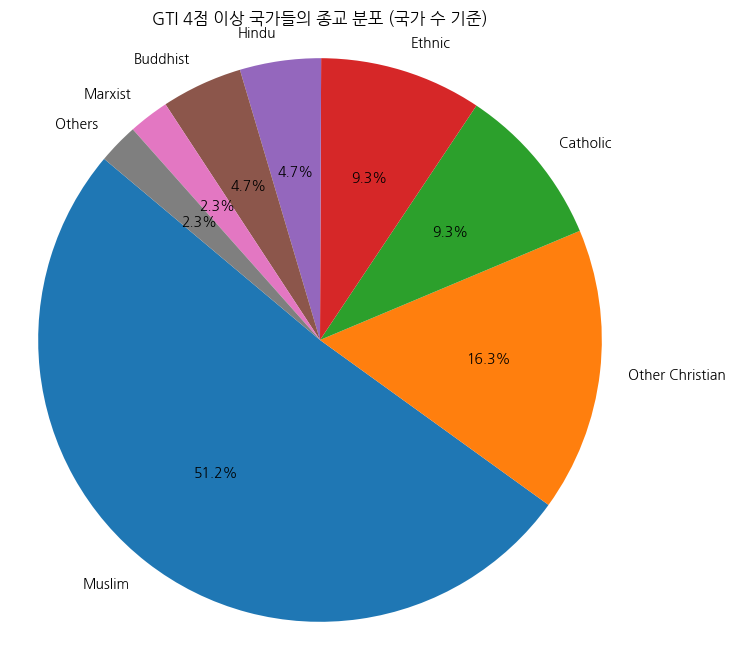

In [26]:
# 종교별 국가 수
religion_counts = merged_religion_gti["religion"].value_counts()

# 파이차트 시각화
plt.figure(figsize=(8, 8))
plt.pie(religion_counts, labels=religion_counts.index, autopct='%1.1f%%', startangle=140)
plt.title("GTI 4점 이상 국가들의 종교 분포 (국가 수 기준)")
plt.axis("equal")
plt.show()

위험도가 4점 이상인 국가들 중 절반이 넘는 51.2%가 무슬림 국가이다. 그 뒤를 이어 민족종교, 카톨릭 등이 12.1%, 9.1%를 차지하였다

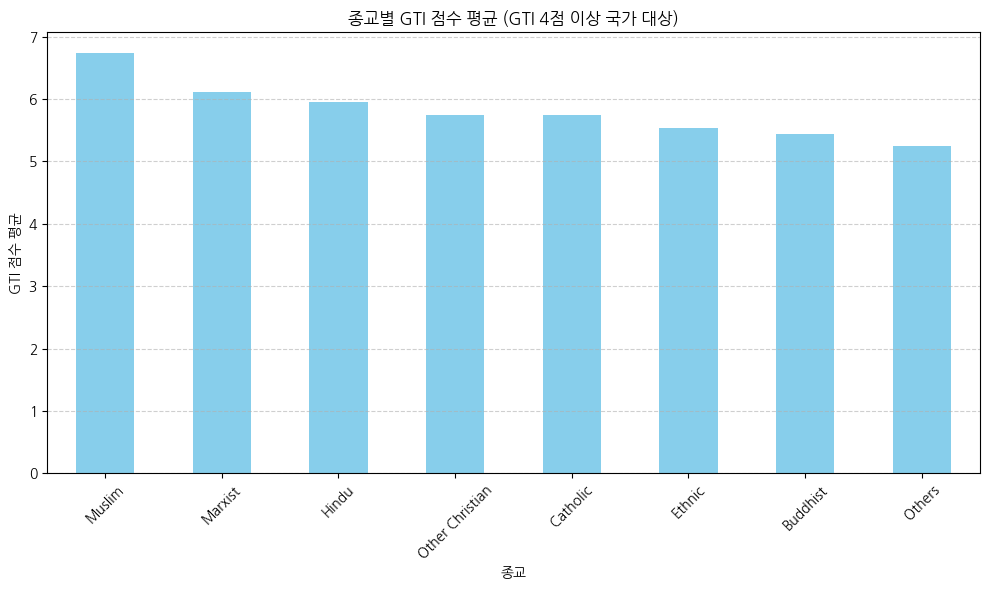

In [27]:
# 종교별 GTI 점수 평균 계산
avg_gti_by_religion = merged_religion_gti.groupby("religion")["GTI_Score"].mean().sort_values(ascending=False)

# 시각화
plt.figure(figsize=(10, 6))
avg_gti_by_religion.plot(kind="bar", color="skyblue")
plt.title("종교별 GTI 점수 평균 (GTI 4점 이상 국가 대상)")
plt.xlabel("종교")
plt.ylabel("GTI 점수 평균")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [28]:
terror_top_20 = terror["Country"].value_counts().head(20).reset_index()
terror_top_20.columns = ["Country", "Terror_Attacks"]

In [32]:
top_20_with_religion = pd.merge(terror_top_20, religion, on="Country", how="left")

top_20_with_religion

,Country,Terror_Attacks,religion
0,Iraq,26195,Muslim
1,Afghanistan,19923,Muslim
2,Pakistan,15006,Muslim
3,India,12658,Hindu
4,Philippines,7273,Catholic
5,Yemen,6083,NaN
6,Nigeria,5804,Muslim
7,Colombia,5433,Catholic
8,Somalia,5317,Muslim
9,Thailand,3892,Buddhist


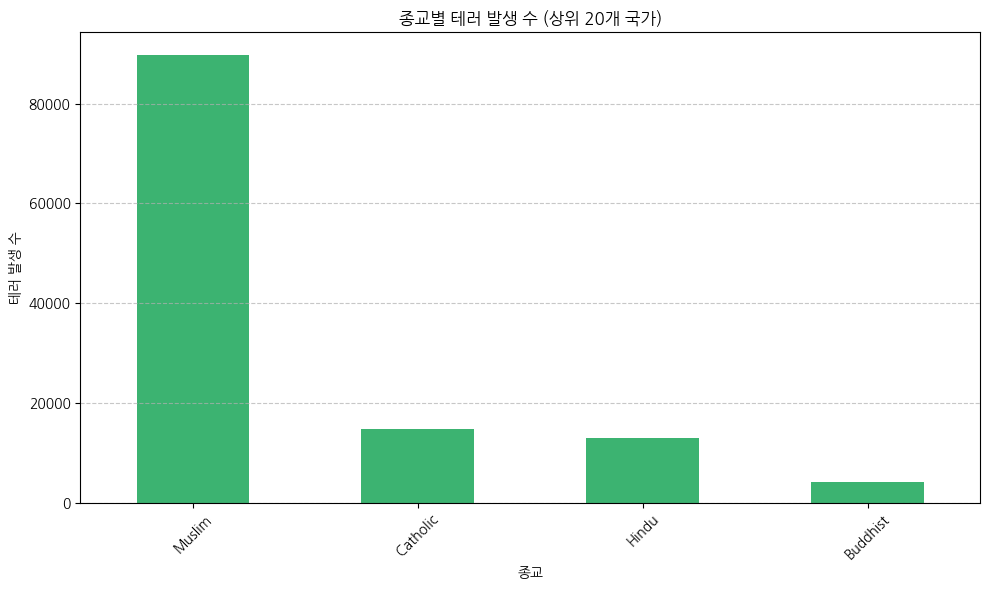

In [ ]:
# 시각화
import matplotlib.pyplot as plt

terror_by_religion_updated = top_20_with_religion.groupby("religion")["Terror_Attacks"].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
terror_by_religion_updated.plot(kind="bar", color="mediumseagreen")
plt.title("종교별 테러 발생 수 (상위 20개 국가)")
plt.xlabel("종교")
plt.ylabel("테러 발생 수")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()



*   GTI-socre가 아닌 실제 테러 수와 비교해봐도 무슬림이 압도적으로 많은 것을 확인할 수 있다.
*   하지만 그렇다고 무슬림이 테러를 종용하는 종교라거나 잘못된 신념이라는 뜻은 아니다.


1.   첫 째로, 무슬림 국가 중 평화로운 나라가 대다수이다.(인도네시아, 말레이시아, 모로코 등)
2.   두번째로, 지정학적 분쟁, 정권의 불안정으로 인한 테러가 다수이다.(이라크, 시리아, 예멘, 아프가니스탄 등)







*   가설 2:
"종교에 따라 테러 위험성이 다르다."
→ 사용한 기법: 일원 분산 분석 (One-way ANOVA)
*   이유:

1.   종교는 범주형 독립변수
2.   테러 위험성은 연속형 종속변수
3.   서로 다른 그룹(종교 집단) 간에 평균의 차이가 있는지를 보고 싶은 것
→ 이럴 땐 ANOVA(분산 분석)이 적절


*   핵심 질문


1.   종교별로 테러 위험 수준 평균이 다르다고 볼 수 있는가?
2.   p-value < 0.05면 차이가 "통계적으로 유의"하다고 해석








In [34]:
# 1. GTI와 종교 정보 병합
merged = pd.merge(GTI_rank, religion, on ='Country',  how='inner')

# 2. 종교별 GTI 점수 그룹 나누기 (컬럼명 반드시 확인!)
groups = merged.groupby('religion')['GTI_Score'].apply(list)

# 3. 일원분산분석 (ANOVA)
from scipy.stats import f_oneway
anova_result = f_oneway(*groups)

# 4. 결과 출력
print("F 통계량:", anova_result.statistic)
print("p-value:", anova_result.pvalue)


F 통계량: 3.806248988935099
p-value: 0.0014150065776272378


In [35]:
terror_with_religion = pd.merge(terror, religion, on="Country", how="left")

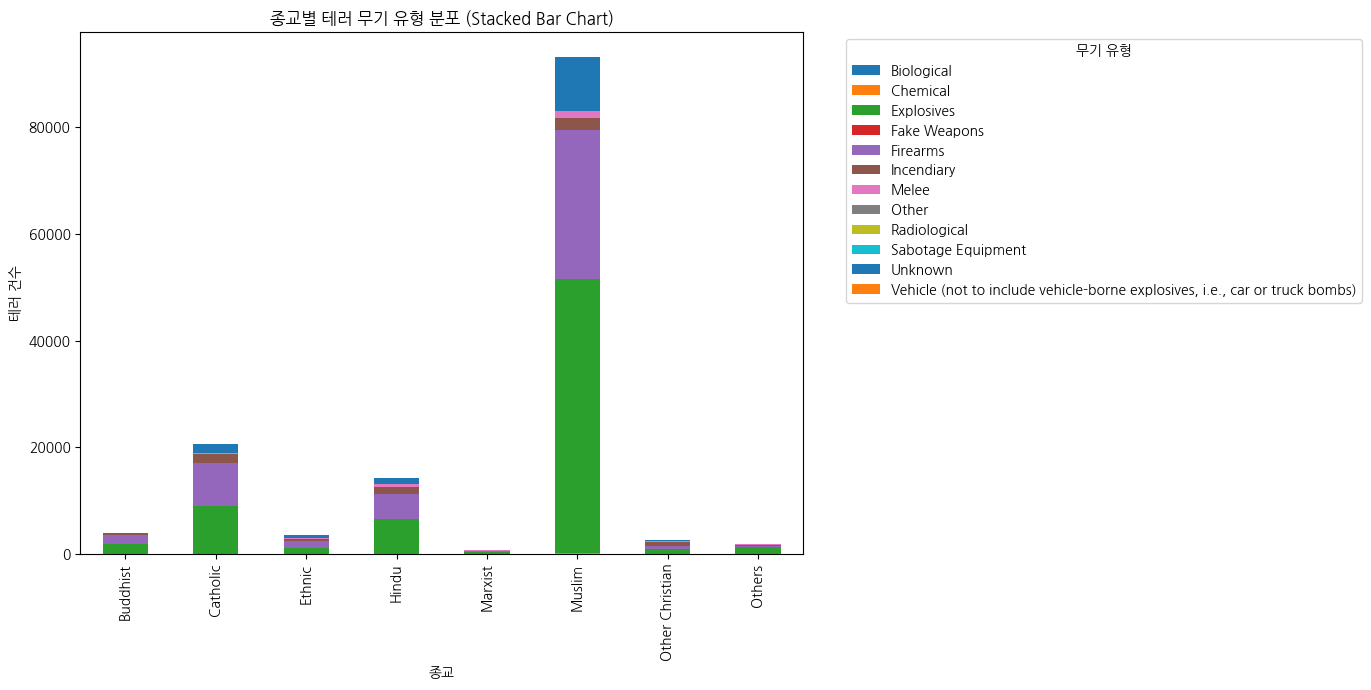

In [36]:
# NaN 없는 행만 필터링
filtered_df = terror_with_religion.dropna(subset=["religion", "weaptype1_txt"])

# 종교별 무기 유형 집계
grouped = (
    filtered_df
    .groupby(['religion', 'weaptype1_txt'])
    .size()
    .reset_index(name='Count')
)

# 피벗 테이블로 변환
pivot_df = (
    grouped
    .pivot(index='religion', columns='weaptype1_txt', values='Count')
    .fillna(0)
)

# Stacked Bar Chart
pivot_df.plot(kind='bar', stacked=True, figsize=(14, 7))
plt.title("종교별 테러 무기 유형 분포 (Stacked Bar Chart)")
plt.xlabel("종교")
plt.ylabel("테러 건수")
plt.legend(title="무기 유형", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
# 종교와 무기 정보가 있는 데이터 필터링
filtered_df = terror_with_religion.dropna(subset=["religion", "weaptype1_txt"])

# 그룹화: 종교별 무기 유형 수
grouped = (
    filtered_df
    .groupby(['religion', 'weaptype1_txt'])
    .size()
    .reset_index(name='Count')
)

# 종교별 총 테러 수
total_by_religion = grouped.groupby('religion')['Count'].sum().reset_index(name='Total')

# 비율 계산을 위해 병합
grouped_with_total = pd.merge(grouped, total_by_religion, on='religion')
grouped_with_total['Percent'] = (grouped_with_total['Count'] / grouped_with_total['Total']) * 100

# 종교별 상위 3개 무기 유형 추출
top1_weapons_by_religion = (
    grouped_with_total
    .sort_values(['religion', 'Percent'], ascending=[True, False])
    .groupby('religion')
    .head(2)
    .reset_index(drop=True)
)

top1_weapons_by_religion

,religion,weaptype1_txt,Count,Total,Percent
0,Buddhist,Explosives,1902,3953,48.115355
1,Buddhist,Firearms,1660,3953,41.993423
2,Catholic,Explosives,8970,20619,43.503565
3,Catholic,Firearms,8118,20619,39.371454
4,Ethnic,Firearms,1431,3484,41.073479
5,Ethnic,Explosives,1071,3484,30.740528
6,Hindu,Explosives,6484,14185,45.710257
7,Hindu,Firearms,4689,14185,33.056045
8,Marxist,Explosives,406,760,53.421053
9,Marxist,Firearms,161,760,21.184211


# 가설 3 : 종교 별 주요 공격 대상이 다를 것이다.

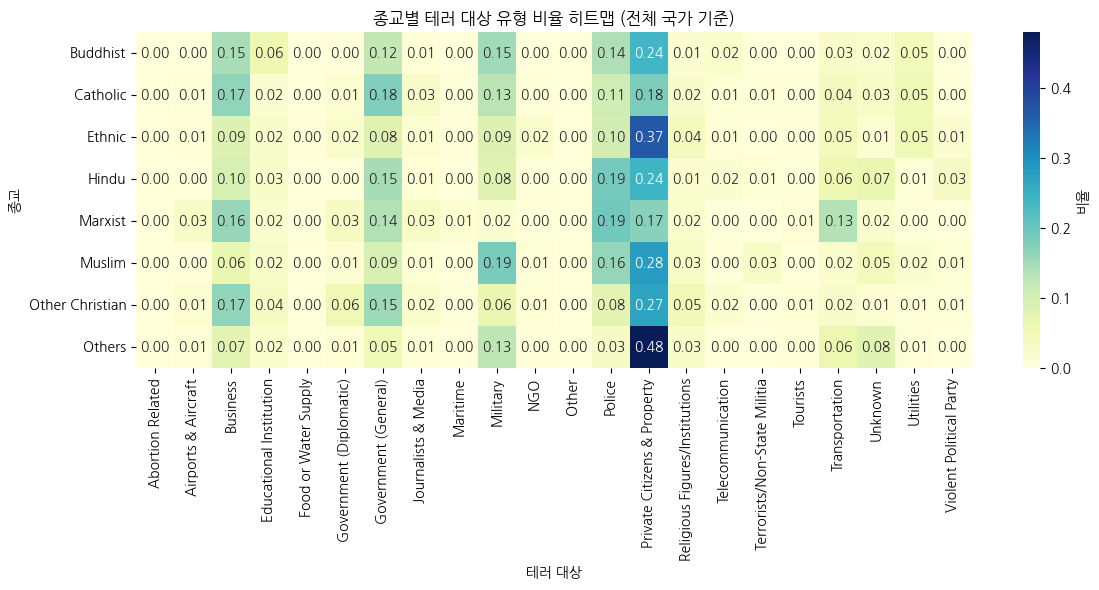

In [ ]:
# 전체 국가 대상 데이터에서 타깃과 국가 추출
all_country_targets = terror[["Country", "targtype1_txt"]].copy()


# 국가 이름 기준 병합
all_country_targets = pd.merge(all_country_targets, religion, on="Country", how="left")

# 종교별 타깃 유형 분포 계산
full_religion_target_dist = all_country_targets.groupby(["religion", "targtype1_txt"]).size().unstack(fill_value=0)

# 비율로 환산
full_religion_target_ratio = full_religion_target_dist.div(full_religion_target_dist.sum(axis=1), axis=0)

# 히트맵 시각화
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.heatmap(full_religion_target_ratio, annot=True, cmap="YlGnBu", fmt=".2f", cbar_kws={'label': '비율'})
plt.title("종교별 테러 대상 유형 비율 히트맵 (전체 국가 기준)")
plt.xlabel("테러 대상")
plt.ylabel("종교")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()



1. 대부분의 종교권에서 민간인(Private Citizens & Property)**이 가장 주요한 테러 대상이었다.
2. Business(사업체)와 Police(경찰)도 일부 종교권에서 높은 비중을 차지했다.
3. Muslim, Catholic, Other Christian 국가들에서는 타깃 유형이 비교적 다양하게 분포되었다.
4. Hindu, Buddhist, Ethnic 국가들은 민간인 공격에 집중된 경향이 뚜렷했다.
5. 전반적으로 사회 혼란과 공포 조성을 위한 민간인 공격이 가장 일반적인 전략으로 나타났다.










*   가설 3:
"종교별로 테러의 공격 대상이 다르다."
→ 사용한 기법: 카이제곱 독립성 검정 (Chi-squared test of independence)
*   이유:

1.   종교: 범주형 변수
2.   공격 대상: 범주형 변수
3.   두 범주형 변수 간에 연관성/독립성을 보고 싶은 것
→ 이럴 땐 카이제곱 검정이 적합

*   핵심 질문


1.   종교에 따라 공격 대상의 분포가 유의미하게 다른가?
2.   p-value < 0.05면 독립이 아님 → 종교와 공격 대상이 관련 있음









In [ ]:
# terror_df에 국가별 종교 정보 붙이기 → 국가명 기준 병합
terror_with_religion = pd.merge(
    terror,
    religion[['Country', 'religion']],  # 종교 컬럼명이 'religion'이라고 가정
    on='Country',
    how='left'  # 모든 테러 사건 유지, 종교 정보 없는 경우는 NaN
)


In [ ]:
from scipy.stats import chi2_contingency

# 종교별 공격 대상 교차표
cross_tab = pd.crosstab(terror_with_religion['religion'], terror_with_religion['targtype1_txt'])

# 카이제곱 검정
chi2, p, dof, expected = chi2_contingency(cross_tab)

print("카이제곱 통계량:", chi2)
print("자유도:", dof)
print("p-value:", p)  # p < 0.05면 종교별 공격 대상 분포 차이 있음


카이제곱 통계량: 15264.509314322371
자유도: 147
p-value: 0.0


# 가설 4 : 수용 난민 수가 늘어나면 테러 수도 늘어날 것이다.

In [13]:
refugee_origin = pd.read_excel('/content/refugee_detailed_by_country.xlsx')

In [14]:
# 필요한 열만 남기고 나머지 삭제
columns_to_keep = ['Year', 'Country of asylum', "Refugees under UNHCR's mandate"]
refugee = refugee_origin[columns_to_keep]

# 컬럼명 변경
refugee = refugee.rename(columns={
    'Country of asylum': 'Country',
    "Refugees under UNHCR's mandate": 'Refugee'
})


In [ ]:
# 1. 국가별 테러 발생 건수 집계
top_5_countries = (
    terror['Country']
    .value_counts()
    .head(5)
    .index
    .tolist()
)

top_5_countries

['Iraq', 'Afghanistan', 'Pakistan', 'India', 'Philippines']

In [ ]:
# 2. 연도별 테러 발생 건수 (Top 5 국가만)
terror_top5 = (
    terror[terror['Country'].isin(top_5_countries)]
    .groupby(['iyear', 'Country'])
    .size()
    .reset_index(name='Terror_Count')
    .rename(columns={'iyear': 'Year', 'Country': 'Country'})
)

# 3. 난민 데이터에서 해당 국가만 필터링
refugee_top5 = refugee[refugee['Country'].isin(top_5_countries)]

# 4. 연도별 국가 기준으로 두 데이터 병합
merged_df = pd.merge(terror_top5, refugee_top5, on=['Year', 'Country'], how='left')

In [ ]:
# 연도-국가별로 난민 수를 합산
refugee_top5_grouped = refugee_top5.groupby(['Year', 'Country'])['Refugee'].sum().reset_index()

# 테러 데이터와 다시 병합
merged_clean_df = pd.merge(terror_top5, refugee_top5_grouped, on=['Year', 'Country'], how='left')


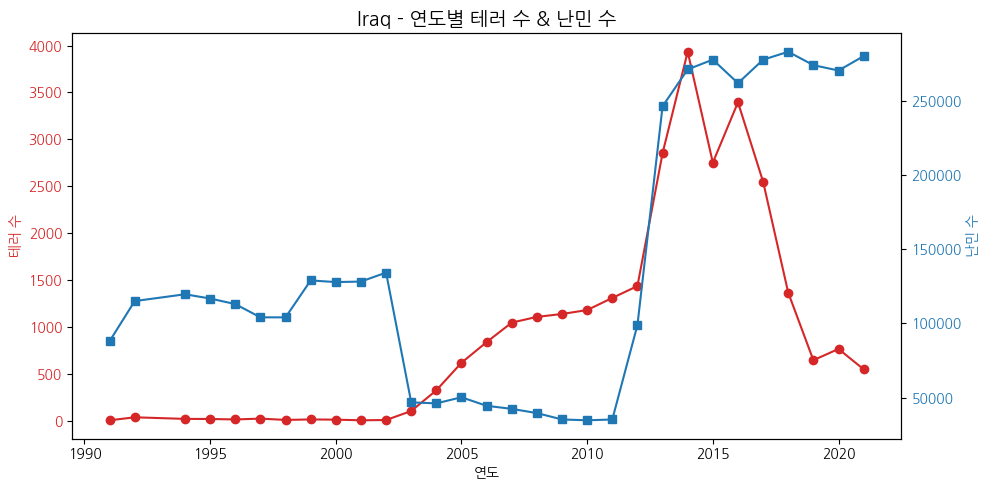

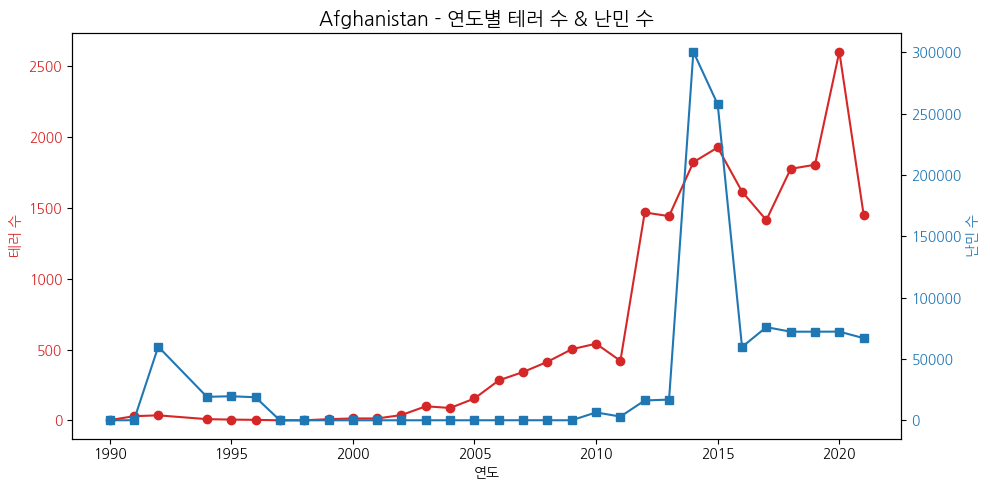

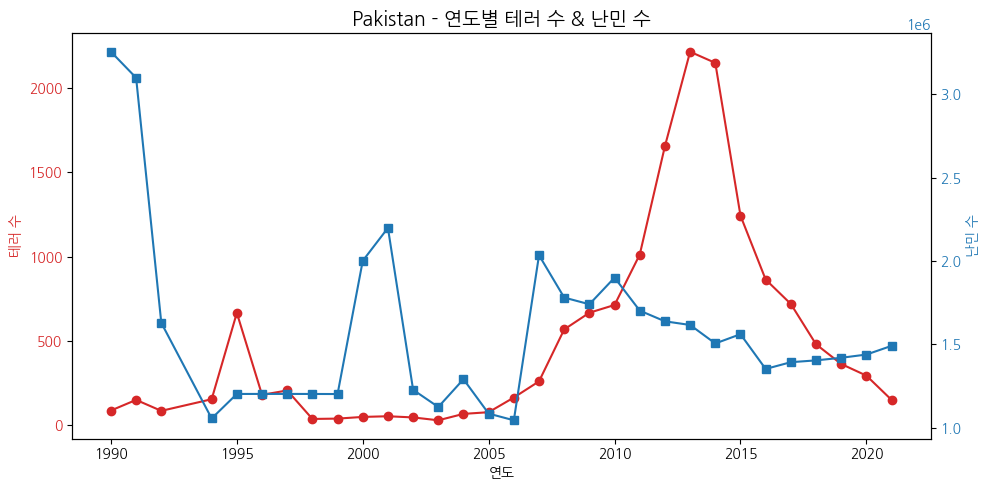

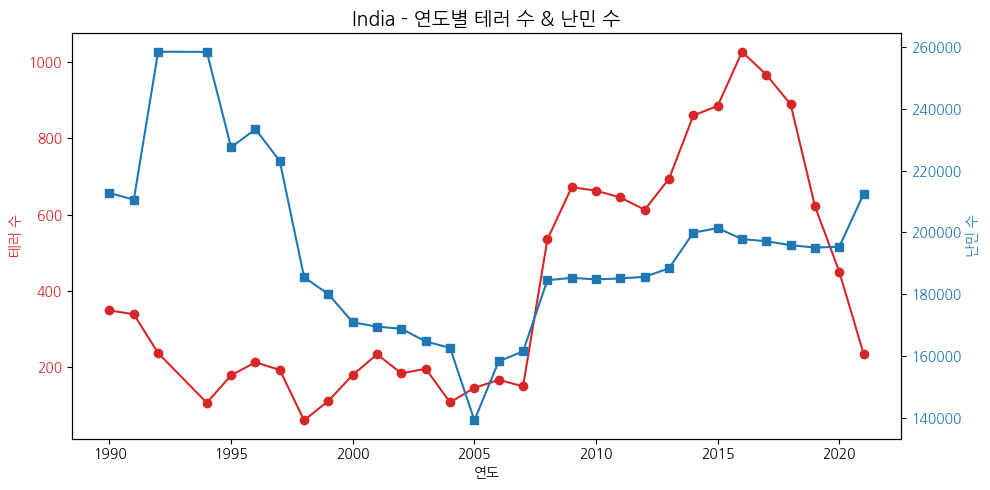

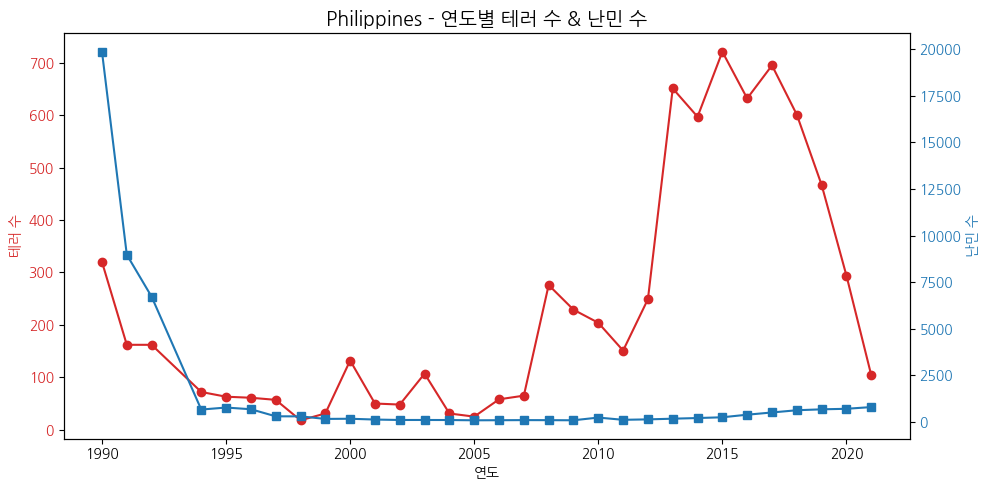

In [ ]:
import matplotlib.pyplot as plt

# 시각화: 각 국가별 연도별 테러 수 & 난민 수 (이중 축 그래프)
for country in top_5_countries:
    country_data = merged_clean_df[merged_clean_df['Country'] == country]

    fig, ax1 = plt.subplots(figsize=(10, 5))
    ax1.set_title(f"{country} - 연도별 테러 수 & 난민 수", fontsize=14)
    ax1.set_xlabel("연도")
    ax1.set_ylabel("테러 수", color='tab:red')
    ax1.plot(country_data['Year'], country_data['Terror_Count'], marker='o', label='테러 수', color='tab:red')
    ax1.tick_params(axis='y', labelcolor='tab:red')

    ax2 = ax1.twinx()
    ax2.set_ylabel("난민 수", color='tab:blue')
    ax2.plot(country_data['Year'], country_data['Refugee'], marker='s', label='난민 수', color='tab:blue')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    plt.tight_layout()
    plt.show()

**이라크** 2013년 테러 급증의 주요 원인
  1. 시리아 내전의 여파 (2011~)


  2. 이라크 내 종파 갈등 심화 (수니파 vs 시아파)


  3. 미군 철수 이후의 치안 공백 (2011년 말 완전 철수)


  4. ISIL의 본격적인 테러 전략 전개 시작점




아프가니스탄 2020년 테러 급증의 주요 원인
  1. 미국-탈레반 평화 협정 체결 (2020.2)

  2. IS-K (이슬람국가 호라산 지부)의 테러 확대

  3. 정부 통제력 약화 & 치안 공백




파키스탄 2013년 테러 급증의 주요 원인
 1. 총선 전후 정치 불안과 정권 교체

 2. 파키스탄 탈레반(TTP)의 활동 강화

 3. 시아파 대상 종교 폭력 증가

 4. 북서부 부족지역의 군사작전과 보복 공격


인도 2015년 테러 급증의 주요 원인
 1. 잠무·카슈미르 지역의 무장 분리주의 운동 지속

 2. 나그랜드·마니푸르 등 북동부 지역의 반군 활동

 3. 마오이스트(공산주의 무장세력, Naxalite) 활동 지속

 4. 파키스탄 국경 인접지역에서의 무장 침투


필리핀 2015년 테러 급증의 주요 원인
 1. 민다나오(Mindanao) 지역의 분리주의 무장 갈등 지속

 2. 마마사파노(Mamasapano) 사건 (2015.1)

 3. 아부 사야프(ASG, Abu Sayyaf Group)의 테러 지속

 4. IS(이슬람국가)의 영향력 확산


In [ ]:
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
import numpy as np

# 테러 상위 5개국 데이터 사용 (NaN 제거)
correlation_df = merged_clean_df[merged_clean_df['Country'].isin(top_5_countries)].dropna()

# 상관관계 분석
correlation_coefficient, p_value = pearsonr(correlation_df['Terror_Count'], correlation_df['Refugee'])

# 회귀 분석
X = correlation_df[['Terror_Count']]  # 독립 변수
y = correlation_df['Refugee']         # 종속 변수

reg_model = LinearRegression()
reg_model.fit(X, y)

# 회귀 결과 예측 및 기울기/절편 저장
slope = reg_model.coef_[0]
intercept = reg_model.intercept_
r_squared = reg_model.score(X, y)

{
    "상관계수 (r)": float(round(correlation_coefficient, 3)),
    "p-value": float(round(p_value, 4)),
    "회귀 기울기 (slope)": float(round(slope, 2)),
    "절편 (intercept)": float(round(intercept, 2)),
    "설명력 (R²)": float(round(r_squared, 3))
}

{'상관계수 (r)': 0.017,
 'p-value': 0.8316,
 '회귀 기울기 (slope)': 15.6,
 '절편 (intercept)': 383542.82,
 '설명력 (R²)': 0.0}

테러 수 top5 국가를 대상으로 상관관계 분석과 회귀분석을 통해 추론 통계한 결과 상관계수 = 0.017이며 p-value가 0.8316으로 거의 관련이 없으며 회귀 기울기는 15.6으로 테러 당 난민 수가 15.6 정도 상승하는 걸로 보아 큰 관련이 없어 보이며 설명력이 약하다.

In [16]:
refugee['Country'] = refugee['Country'].replace({'Türkiye': 'Turkey', 'Iran (Islamic Rep. of)': 'Iran'})


# 난민 수가 가장 많은 상위 5개 국가 (수용국 기준)
top5_refugee_countries = (
    refugee.groupby('Country')['Refugee']
    .sum()
    .sort_values(ascending=False)
    .head(5)
    .index
    .tolist()
)

top5_refugee_countries

['Iran', 'Pakistan', 'Germany', 'Turkey', 'Sudan']

In [40]:
# 수용 난민 수 상위 5개국 추출
top5_host_countries = refugee.groupby("Country")["Refugee"].sum().nlargest(5).reset_index()
top5_host_countries.columns = ["Country of Asylum", "Total Refugees"]

top5_host_countries

,Country of Asylum,Total Refugees
0,Iran,50506683
1,Pakistan,50485218
2,Germany,27633293
3,Turkey,26266053
4,Sudan,15312731


In [17]:
# 병합 준비
refugee_top5_host_final = refugee[refugee['Country'].isin(top5_refugee_countries)]
refugee_host_grouped_final = refugee_top5_host_final.groupby(['Year', 'Country'])['Refugee'].sum().reset_index()

terror_host_top5_final = (
    terror[terror['Country'].isin(top5_refugee_countries)]
    .groupby(['iyear', 'Country'])
    .size()
    .reset_index(name='Terror_Count')
    .rename(columns={'iyear': 'Year', 'Country': 'Country'})
)

# 병합
merged_host_final = pd.merge(refugee_host_grouped_final, terror_host_top5_final, on=['Year', 'Country'], how='left')

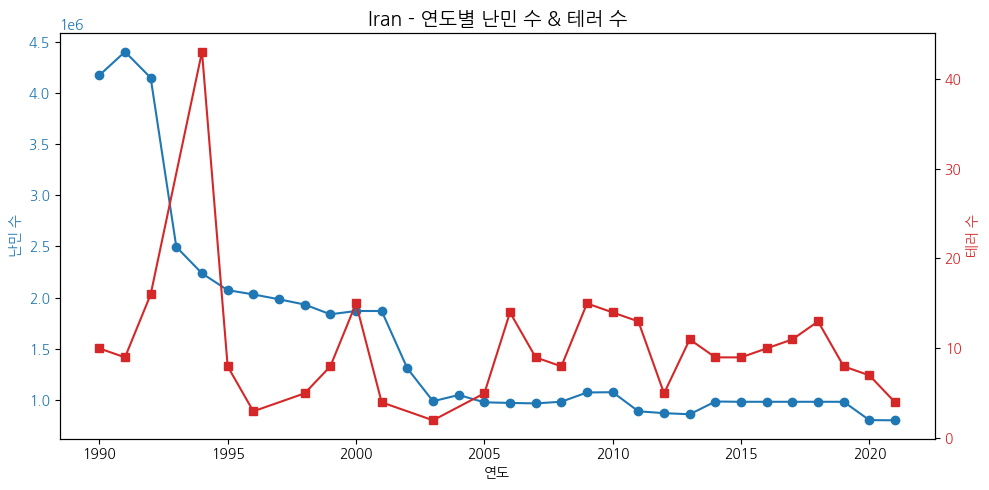

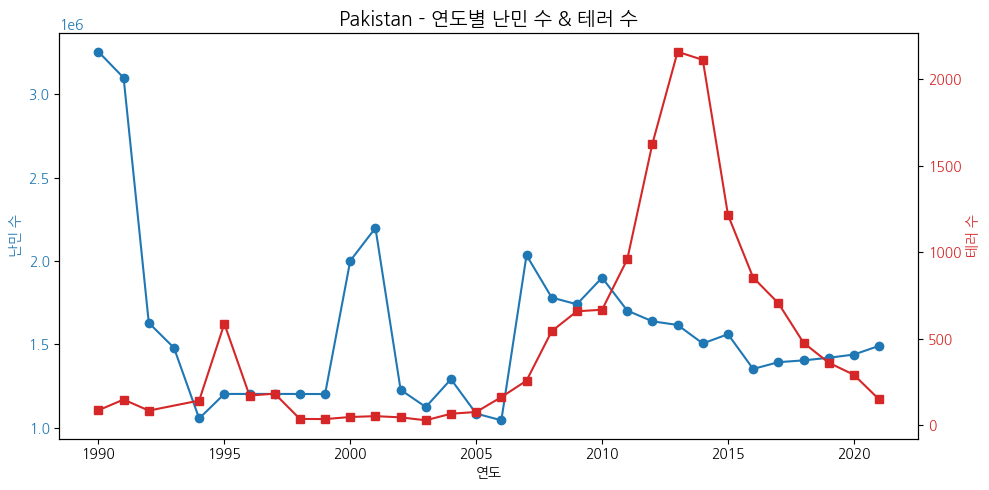

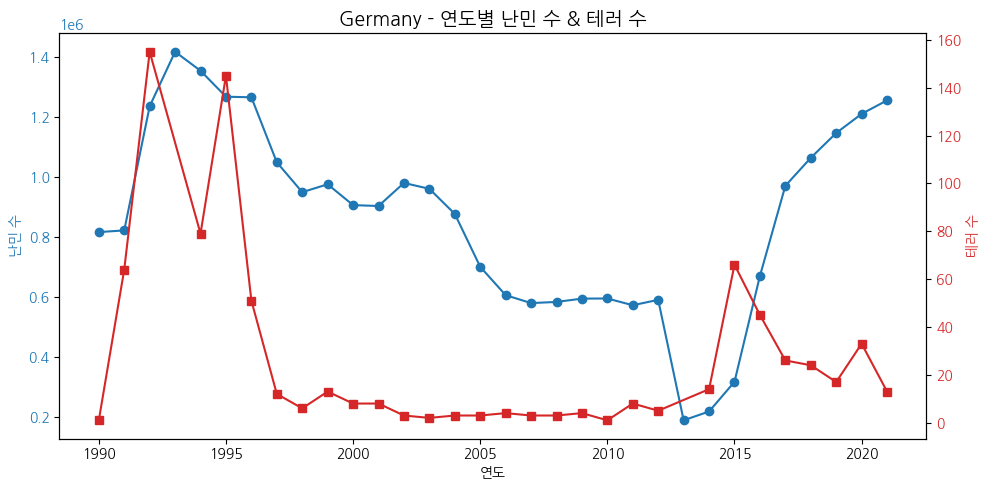

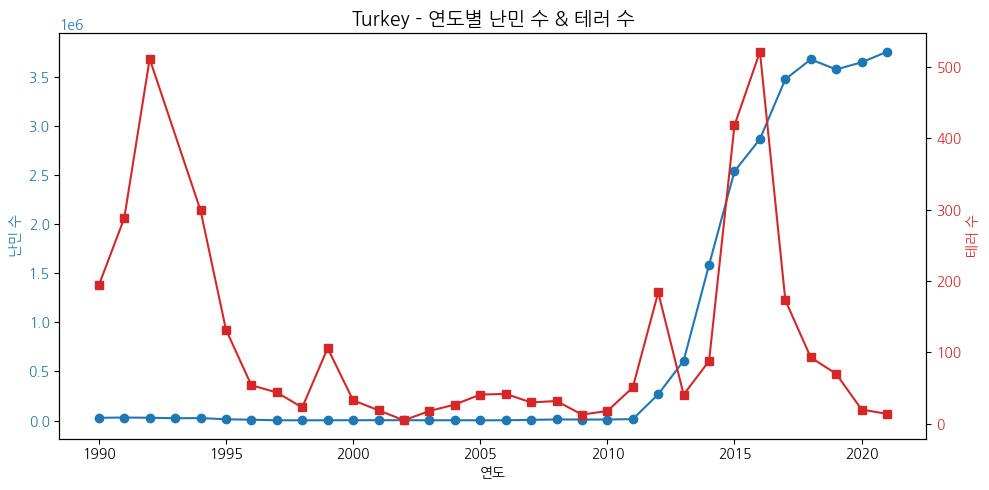

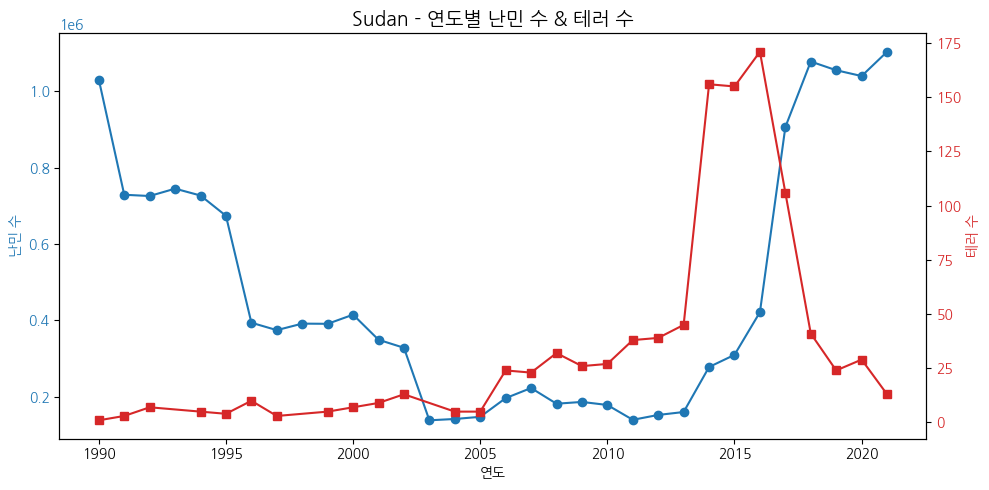

In [ ]:
# 시각화: 최종 정리
for country in top5_refugee_countries:
    country_data = merged_host_final[merged_host_final['Country'] == country]

    fig, ax1 = plt.subplots(figsize=(10, 5))
    ax1.set_title(f"{country} - 연도별 난민 수 & 테러 수", fontsize=14)
    ax1.set_xlabel("연도")
    ax1.set_ylabel("난민 수", color='tab:blue')
    ax1.plot(country_data['Year'], country_data['Refugee'], marker='o', label='난민 수', color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    # 테러 수 NaN 제외
    terror_data = country_data.dropna(subset=['Terror_Count'])
    ax2 = ax1.twinx()
    ax2.set_ylabel("테러 수", color='tab:red')
    ax2.plot(terror_data['Year'], terror_data['Terror_Count'], marker='s', label='테러 수', color='tab:red')
    ax2.tick_params(axis='y', labelcolor='tab:red')

    plt.tight_layout()
    plt.show()

이란의 1994년 테러 급증의 주요 원인

1. AMIA 테러	이란이 배후로 지목됨 (국제적 이미지 악화)
2. 반체제 세력과 충돌	내외부적 테러 활동 증가
3. 무장 단체 지원	헤즈볼라 등 지원으로 국제 사회에서 ‘테러 후원국’ 이미지
4. 국제 제재	고립 속에 급진화된 외교 정책

독일의 2015년 테러 급증의 주요 원인
1.  시리아 내전과 난민 대량 유입
2.  IS(이슬람국가)의 유럽 테러 확대 전략
3.  극우주의와 반이슬람 테러도 증가
4.  공권력 및 정보기관의 경계 강화

튀르키예의 2015년 테러 급증의 주요 원인
1. IS(이슬람국가, 다에시)의 직접적인 공격
2. 쿠르드족 문제와 내전 재개
3. 정치적 불안정과 선거 이슈
4. 시리아 전쟁과 난민 문제

수단의 2015년 테러 급증의 주요 원인
1. IS 및 극단주의 조직의 침투 시도
2. 다르푸르 지역의 무장 충돌 지속
3. 남수단과의 국경 긴장 상태

In [ ]:
# 난민 수 기준 상위 5개국 대상 데이터프레임 준비
refugee_corr_df = merged_host_final[merged_host_final['Country'].isin(top5_refugee_countries)].dropna()

# 상관계수
corr_r, corr_p = pearsonr(refugee_corr_df['Terror_Count'], refugee_corr_df['Refugee'])

# 회귀 분석
X_r = refugee_corr_df[['Terror_Count']]
y_r = refugee_corr_df['Refugee']

reg_model_r = LinearRegression()
reg_model_r.fit(X_r, y_r)

# 결과 요약
slope_r = reg_model_r.coef_[0]
intercept_r = reg_model_r.intercept_
r_squared_r = reg_model_r.score(X_r, y_r)

{
    "상관계수 (r)": float(round(corr_r, 3)),
    "p-value": float(round(corr_p, 4)),
    "회귀 기울기 (slope)": float(round(slope_r, 2)),
    "절편 (intercept)": float(round(intercept_r, 2)),
    "설명력 (R²)": float(round(r_squared_r, 3))
}

{'상관계수 (r)': 0.162,
 'p-value': 0.049,
 '회귀 기울기 (slope)': 465.86,
 '절편 (intercept)': 1002204.48,
 '설명력 (R²)': 0.026}

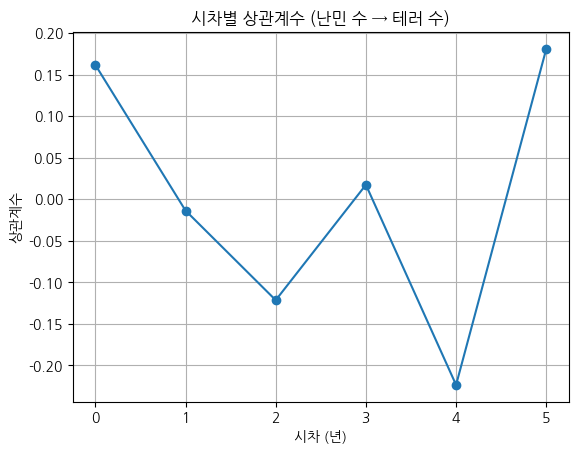

,시차 (년),상관계수
0,0,0.161587
1,1,-0.013683
2,2,-0.121478
3,3,0.017333
4,4,-0.223472
5,5,0.180828


In [19]:
# 최대 시차 설정 (예: 5년)
max_lag = 5
lags = list(range(0, max_lag + 1))
correlations = []

# 시차별 상관계수 계산
for lag in lags:
    shifted_refugee = merged_host_final["Refugee"].shift(lag)
    corr = shifted_refugee.corr(merged_host_final["Terror_Count"])
    correlations.append(corr)

# 시각화
plt.plot(lags, correlations, marker='o')
plt.title("시차별 상관계수 (난민 수 → 테러 수)")
plt.xlabel("시차 (년)")
plt.ylabel("상관계수")
plt.grid(True)
plt.xticks(lags)
plt.show()

# 결과도 표로 함께 출력
pd.DataFrame({"시차 (년)": lags, "상관계수": correlations})

난민 수 top5 국가를 대상으로 봤을 때 상관계수 = 0.163으로 약한 양의 상관관계를 띄며 p-vlaue가 0.0473으로 유의미함을 나타낸다. 또한 회귀 기울기는 457.7로 테러 당 난민 수가 약 457명 정도 늘어남을 확인할 수 있다.



*   가설 4: "난민 수가 늘어나면 테러 수도 늘어날 것이다." -> 사용한 기법: 상관관계 분석 및 회귀분석
*   이유:

1.   두 변수 모두 수치형 변수이기 때문
2.   관계의 방향성과 강도, 그리고 예측 가능성까지 함께 확인할 수 있기 때문
3.   데이터가 시간 축에 따라 측정된 ‘패널 형태’여서 단일 비교보다 추세 분석이 적합하기 때문



*   핵심 질문


1.   난민을 더 많이 수용하는 국가는 테러가 더 많이 일어나는가?
2.   테러 수와 난민 수 사이에 통계적으로 유의미한 관계가 존재하는가?








